In [2670]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from scipy import stats


In [2671]:
# train_file = pd.read_csv('https://drive.google.com/uc?id=16dGSp_T6FhylyckqWJEXQzUi5sZH0heW') ## train.csv
# target_file = pd.read_csv('https://drive.google.com/uc?id=1QCZa0_m1WzW2OsJYzJXOWY4QFnvFFfmK') ## target.csv
# test_file = pd.read_csv('https://drive.google.com/uc?id=18wzEa16ntCFSup1VSF028pGqoGayejuH') ## test.csv


train_file = pd.read_csv('train.csv') ## train.csv
target_file = pd.read_csv('target.csv') ## target.csv
test_file = pd.read_csv('test.csv') ## test.csv

train_copy = train_file.copy() ## untuk perbandingan nanti
target_copy = target_file.copy() ## untuk perbandingan nanti
test_copy = test_file.copy() ## untuk perbandingan nanti


In [2672]:
train = pd.concat([train_file,target_file["coppaRisk"]], axis =1)
train['coppaRisk'] = train['coppaRisk'].astype(int)
train_original = train.copy()
test = test_file.copy()

## Exploratory Data Analysis

In [2673]:
# # Basic information
# print("Dataset shape:", train.shape)
# print("\nData types:")
# print(train.dtypes)

# # Missing values
# missing = train.isnull().sum()
# missing_percent = 100 * missing / len(train)
# missing_data = pd.DataFrame({'Missing Count': missing,
#                              'Missing Percent': missing_percent})
# print("\nMissing values:")
# print(missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Percent', ascending=False))

# # Target variable
# print("\nTarget variable distribution:")
# print(train['coppaRisk'].value_counts())
# print(100 * train['coppaRisk'].value_counts() / len(train))

# # Add numeric version of target for analysis
# train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# # Numeric features basic stats
# numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# print("\nNumeric columns statistics:")
# print(train[numeric_cols].describe())

# # Skewness
# print("\nSkewness of numeric features:")
# print(train[numeric_cols].skew())

# # Enhanced categorical analysis
# categorical_cols = [
#     'developerCountry', 'countryCode', 'primaryGenreName', 'deviceType',
#     'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating',
#     'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating'
# ]

# print("\n" + "="*50)
# print("CATEGORICAL COLUMNS ANALYSIS")
# print("="*50)

# for col in categorical_cols:
#     unique_values = train[col].nunique()
#     missing = train[col].isnull().sum()
#     missing_percent = 100 * missing / len(train)

#     print(f"\n{col}:")
#     print(f"- Unique values: {unique_values}")
#     print(f"- Missing values: {missing} ({missing_percent:.2f}%)")
#     print(f"- Most common values:")

#     # Get value counts and percentages
#     value_counts = train[col].value_counts().head(5)
#     value_percents = 100 * train[col].value_counts(normalize=True).head(5)

#     # Display top 5 values with counts and percentages
#     for val, count, percent in zip(value_counts.index, value_counts, value_percents):
#         print(f"  {val}: {count} ({percent:.2f}%)")

#     # Calculate risk rate for each value
#     risk_by_value = train.groupby(col)['coppaRisk_numeric'].agg(['count', 'mean'])
#     risk_by_value = risk_by_value[risk_by_value['count'] >= 10]  # Min 10 samples
#     risk_by_value = risk_by_value.sort_values('mean', ascending=False)

#     print(f"- Top 10 values by COPPA risk rate (min 10 samples):")
#     for val, stats in risk_by_value.head(10).iterrows():
#         print(f"  {val}: {stats['mean']*100:.2f}% risk ({stats['count']} samples)")

# # Special handling for downloads
# print("\n" + "="*50)
# print("DOWNLOADS ANALYSIS")
# print("="*50)

# # Extract minimum downloads from ranges
# def extract_min_max(downloads_str):
#     if pd.isna(downloads_str):
#         return np.nan, np.nan
#     try:
#         parts = downloads_str.split(' - ')
#         return int(parts[0]), int(parts[1])
#     except:
#         return np.nan, np.nan

# # Apply extraction to non-null values
# download_min_max = train['downloads'].dropna().apply(lambda x: pd.Series(extract_min_max(x), index=['min', 'max']))
# train_with_downloads = train.join(download_min_max)

# print(f"\nUnique download ranges: {train['downloads'].nunique()}")

# # Print some of the unique download ranges
# unique_ranges = train['downloads'].dropna().unique()
# print("\nSample of download ranges:")
# # for range_val in sorted(unique_ranges)[:15]:  # Show first 15 sorted ranges
# for range_val in (unique_ranges):  # Show first 15 sorted ranges
#     print(f"  {range_val}")

# # Count occurrences of each range
# # range_counts = train['downloads'].value_counts().head(10)
# range_counts = train['downloads'].value_counts()
# print("\nMost common download ranges:")
# for range_val, count in range_counts.items():
#     print(f"  {range_val}: {count} occurrences")

# print(f"Missing download values: {train['downloads'].isnull().sum()} ({100*train['downloads'].isnull().sum()/len(train):.2f}%)")

# print("\nDistribution of minimum downloads:")
# min_downloads_bins = [0, 10, 100, 1000, 10000, 100000, float('inf')]
# min_downloads_labels = ['0-10', '11-100', '101-1K', '1K-10K', '10K-100K', '>100K']
# download_counts = pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels).value_counts().sort_index()
# download_percents = 100 * download_counts / download_counts.sum()

# for label, count, percent in zip(download_counts.index, download_counts, download_percents):
#     print(f"  {label}: {count} ({percent:.2f}%)")

# # Calculate COPPA risk by download range
# download_risk = train_with_downloads.groupby(pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels))['coppaRisk_numeric'].mean() * 100
# print("\nCOPPA risk by download range:")
# for label, risk in zip(download_risk.index, download_risk):
#     print(f"  {label}: {risk:.2f}% risk")

# # Cross-tabulation of key categorical features
# print("\n" + "="*50)
# print("CROSS-TABULATION ANALYSIS")
# print("="*50)

# # Genre and device type
# print("\nPrimary genres by device type (top 5 combinations):")
# genre_device = pd.crosstab(train['primaryGenreName'], train['deviceType'])
# print(genre_device.unstack().sort_values(ascending=False).head(5))

# # Genre and risk
# print("\nRisk rate by top genres and privacy policy:")
# top_genres = train['primaryGenreName'].value_counts().head(5).index
# genre_privacy_risk = train[train['primaryGenreName'].isin(top_genres)].groupby(['primaryGenreName', 'hasPrivacyLink'])['coppaRisk_numeric'].agg(['count', 'mean'])
# print(genre_privacy_risk.sort_values(by=['primaryGenreName', 'mean'], ascending=[True, False]))

# # Feature importance estimation using mutual information
# print("\n" + "="*50)
# print("FEATURE IMPORTANCE ESTIMATION")
# print("="*50)

# try:
#     from sklearn.feature_selection import mutual_info_classif

#     # Prepare data for feature importance
#     features_for_mi = train[numeric_cols].copy()
#     for col in features_for_mi.columns:
#         features_for_mi[col] = features_for_mi[col].fillna(features_for_mi[col].median())

#     # Calculate mutual information
#     mi_scores = mutual_info_classif(features_for_mi, train['coppaRisk_numeric'])
#     mi_results = pd.Series(mi_scores, index=features_for_mi.columns)

#     print("\nFeature importance by mutual information:")
#     for feature, score in mi_results.sort_values(ascending=False).items():
#         print(f"  {feature}: {score:.4f}")
# except:
#     print("\nSkikit-learn not available for mutual information calculation")

In [2674]:
# # Check unique values first
# print("Unique values in coppaRisk column:", train['coppaRisk'].unique())

# # Convert to numeric properly
# train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# # Verify our conversion worked
# print("\nTarget distribution after conversion:")
# print(train['coppaRisk_numeric'].value_counts())
# print(f"Percentage of True: {100 * train['coppaRisk_numeric'].mean():.2f}%")

# # 1. Missing values visualization
# missing = train.isnull().sum().sort_values(ascending=False)
# missing_percent = 100 * missing / len(train)
# missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_percent})
# missing_df = missing_df[missing_df['Missing Count'] > 0]

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x=missing_df.index, y='Missing Percent', data=missing_df)
# plt.title('Percentage of Missing Values by Column')
# plt.xticks(rotation=90)
# plt.ylabel('Percent Missing')
# plt.tight_layout()
# plt.show()

# # 2. Target variable distribution
# plt.figure(figsize=(8, 5))
# ax = sns.countplot(x='coppaRisk', data=train)
# plt.title('Distribution of COPPA Risk (Target Variable)')

# # Add percentage labels
# total = len(train)
# for i, p in enumerate(ax.patches):
#     percentage = f'{100 * p.get_height() / total:.1f}%'
#     ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
#                 ha='center', va='bottom')
# plt.tight_layout()
# plt.show()

# # 3. Correlation matrix - fixed to show all correlations including target
# numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# # Add target to the list
# cols_with_target = numeric_cols + ['coppaRisk_numeric']

# # Fill missing values for correlation calculation only
# corr_df = train[cols_with_target].copy()
# for col in numeric_cols:
#     corr_df[col] = corr_df[col].fillna(corr_df[col].median())

# corr_matrix = corr_df.corr()
# print("\nCorrelation matrix with target:")
# print(corr_matrix['coppaRisk_numeric'].sort_values(ascending=False))

# # Plot full correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Matrix of Numeric Features')
# plt.tight_layout()
# plt.show()

# # 4. Bar chart of feature correlations with target
# plt.figure(figsize=(10, 6))
# target_corrs = corr_matrix['coppaRisk_numeric'].drop('coppaRisk_numeric').sort_values(ascending=False)
# ax = sns.barplot(x=target_corrs.index, y=target_corrs.values)
# plt.title('Feature Correlations with COPPA Risk')
# plt.xticks(rotation=45)
# plt.ylabel('Correlation Coefficient')
# plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# # Add correlation values as text
# for i, v in enumerate(target_corrs.values):
#     ax.text(i, v + 0.01 if v >= 0 else v - 0.03, f"{v:.2f}", ha='center')

# plt.tight_layout()
# plt.show()

# # 5. Genre vs COPPA risk - FIXED
# # Calculate risk rate by genre properly
# genre_risk = train.groupby('primaryGenreName')['coppaRisk_numeric'].agg(['count', 'mean'])
# genre_risk = genre_risk[genre_risk['count'] >= 20]  # Min 20 apps per genre
# genre_risk = genre_risk.sort_values('mean', ascending=False)
# genre_risk['mean'] = genre_risk['mean'] * 100  # Convert to percentage

# print("\nCOPPA risk rate by genre (min 20 apps):")
# print(genre_risk.head(10))

# plt.figure(figsize=(14, 7))
# ax = sns.barplot(x=genre_risk.index[:10], y='mean', data=genre_risk[:10])
# plt.title('COPPA Risk Rate by Genre (min 20 apps)')
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Risk Rate (%)')

# # Add percentage labels
# for i, v in enumerate(genre_risk['mean'][:10]):
#     ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

# plt.tight_layout()
# plt.show()

# # 6. Privacy policy vs COPPA risk - FIXED
# privacy_risk = train.groupby('hasPrivacyLink')['coppaRisk_numeric'].agg(['count', 'mean'])
# privacy_risk['mean'] = privacy_risk['mean'] * 100  # Convert to percentage

# print("\nCOPPA risk by privacy policy presence:")
# print(privacy_risk)

# plt.figure(figsize=(8, 5))
# ax = sns.barplot(x=privacy_risk.index, y='mean', data=privacy_risk)
# plt.title('COPPA Risk Rate by Privacy Policy Presence')
# plt.ylabel('Risk Rate (%)')

# # Add percentage labels
# for i, v in enumerate(privacy_risk['mean']):
#     ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

# plt.tight_layout()
# plt.show()

# # 7. Box plots for key numerical features
# for col in ['userRatingCount', 'isCorporateEmailScore', 'appAge', 'averageUserRating']:
#     plt.figure(figsize=(10, 6))
#     ax = sns.boxplot(x='coppaRisk', y=col, data=train)
#     plt.title(f'{col} by COPPA Risk Status')
#     # For very skewed features, use log scale
#     if train[col].skew() > 5 and (train[col] > 0).all():
#         plt.yscale('log')
#         plt.ylabel(f'{col} (log scale)')
#     plt.tight_layout()
#     plt.show()

# # 8. Distribution of downloads (min range)
# if 'downloads' in train.columns:
#     # Extract minimum downloads from the range
#     def extract_min(downloads_str):
#         if pd.isna(downloads_str):
#             return np.nan
#         try:
#             return int(downloads_str.split(' - ')[0])
#         except:
#             return np.nan

#     train['min_downloads'] = train['downloads'].apply(extract_min)

#     plt.figure(figsize=(12, 6))
#     ax = sns.boxplot(x='coppaRisk', y='min_downloads', data=train)
#     plt.title('Minimum Downloads by COPPA Risk')
#     plt.yscale('log')
#     plt.ylabel('Minimum Downloads (log scale)')
#     plt.tight_layout()
#     plt.show()

#     # Calculate COPPA risk by download range (binned)
#     def categorize_downloads(min_val):
#         if pd.isna(min_val):
#             return 'Unknown'
#         elif min_val < 100:
#             return '<100'
#         elif min_val < 1000:
#             return '100-1K'
#         elif min_val < 10000:
#             return '1K-10K'
#         elif min_val < 100000:
#             return '10K-100K'
#         else:
#             return '>100K'

#     train['download_bin'] = train['min_downloads'].apply(categorize_downloads)

#     download_risk = train.groupby('download_bin')['coppaRisk_numeric'].agg(['count', 'mean'])
#     download_risk = download_risk[download_risk['count'] >= 20]
#     download_risk['mean'] = download_risk['mean'] * 100

#     plt.figure(figsize=(10, 6))
#     ax = sns.barplot(x=download_risk.index, y='mean', data=download_risk)
#     plt.title('COPPA Risk Rate by Download Range')
#     plt.ylabel('Risk Rate (%)')

#     # Add percentage labels
#     for i, v in enumerate(download_risk['mean']):
#         ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

#     plt.tight_layout()
#     plt.show()

In [2675]:
# # only use for visualization
# train = train.drop(['download_bin', 'coppaRisk_numeric','min_downloads'], axis=1, errors='ignore')

In [2676]:
def analyze_raw_features(df, target_column='coppaRisk', categorical_threshold=10, top_n=10,
                        high_missing_threshold=0.3):
    """
    Analyze raw features in the original dataframe to identify which are most predictive

    Parameters:
    -----------
    df : DataFrame
        Original dataframe with features and target
    target_column : str, default='coppaRisk'
        Name of the target column
    categorical_threshold : int, default=10
        Max unique values to consider a feature categorical
    top_n : int, default=10
        Number of top features to display
    high_missing_threshold : float, default=0.3
        Threshold to flag features with high missing values (30% by default)

    Returns:
    --------
    dict
        Dictionary with analysis results
    """
    
    from scipy import stats
    
    print(f"\n{'='*60}")
    print("RAW FEATURE ANALYSIS")
    print(f"{'='*60}")

    # Extract target and features
    y = df[target_column]
    X = df.drop(columns=[target_column])

    # Analyze missing values first
    print(f"\n{'='*30} MISSING VALUES ANALYSIS {'='*30}")
    missing_analysis = {}
    features_with_high_missing = []

    print(f"{'Feature':<30} {'Missing Count':<15} {'Missing %':<15} {'Status':<15}")
    print("-" * 75)

    for col in X.columns:
        missing_count = X[col].isnull().sum()
        missing_pct = missing_count / len(X) * 100
        status = "High Missing" if missing_pct >= high_missing_threshold * 100 else "OK"

        if missing_pct >= high_missing_threshold * 100:
            features_with_high_missing.append(col)

        missing_analysis[col] = {
            'missing_count': missing_count,
            'missing_pct': missing_pct,
            'is_high_missing': missing_pct >= high_missing_threshold * 100
        }

        print(f"{col:<30} {missing_count:<15} {missing_pct:>10.2f}% {'⚠️ ' + status if status != 'OK' else status:<15}")

    print(f"\nFound {len(features_with_high_missing)} features with high missing values (>{high_missing_threshold*100}%)")
    if features_with_high_missing:
        print("Features with high missing values: " + ", ".join(features_with_high_missing))

    # Separate categorical and numerical features
    categorical_features = []
    numerical_features = []

    for col in X.columns:
        if X[col].nunique() <= categorical_threshold:
            categorical_features.append(col)
        elif pd.api.types.is_numeric_dtype(X[col]):
            numerical_features.append(col)

    print(f"\nFound {len(categorical_features)} categorical features and {len(numerical_features)} numerical features")

    # Initialize storage for results
    analysis_results = {
        'missing_analysis': missing_analysis,
        'features_with_high_missing': features_with_high_missing,
        'numerical_importance': {},
        'categorical_importance': {},
        'most_important_features': []
    }

    # Analyze numerical features
    print(f"\n{'='*30} NUMERICAL FEATURES {'='*30}")
    numerical_importance = {}

    for col in numerical_features:
        # Skip if all values are missing
        if X[col].isna().all():
            continue

        # Get missing percentage for this feature
        missing_pct = missing_analysis[col]['missing_pct']

        # Basic statistics by class
        class_0_data = X[col][y == 0].dropna()
        class_1_data = X[col][y == 1].dropna()

        if len(class_0_data) == 0 or len(class_1_data) == 0:
            continue

        class_0_mean = class_0_data.mean()
        class_1_mean = class_1_data.mean()
        mean_diff = abs(class_1_mean - class_0_mean)
        mean_diff_pct = mean_diff / max(abs(class_0_mean), 1e-10) * 100

        # Perform t-test
        try:
            t_stat, p_value = stats.ttest_ind(class_0_data, class_1_data, equal_var=False)
            is_significant = p_value < 0.05
        except:
            p_value = 1.0
            is_significant = False

        # Calculate point-biserial correlation (correlation with binary target)
        valid_indices = ~X[col].isna()
        if valid_indices.sum() > 0:
            correlation = stats.pointbiserialr(y[valid_indices], X[col][valid_indices])[0]
        else:
            correlation = 0

        # Calculate reliability-adjusted importance (penalize high missing values)
        reliability_factor = max(0, 1 - (missing_pct / 100) * 2)  # Linear penalty
        importance_score = abs(correlation) * reliability_factor

        numerical_importance[col] = importance_score

        # Store in results
        analysis_results['numerical_importance'][col] = {
            'correlation': correlation,
            'p_value': p_value,
            'class_0_mean': class_0_mean,
            'class_1_mean': class_1_mean,
            'mean_diff_pct': mean_diff_pct,
            'is_significant': is_significant,
            'missing_pct': missing_pct,
            'reliability_factor': reliability_factor,
            'importance_score': importance_score
        }

    # Sort numerical features by reliability-adjusted importance
    sorted_numerical = sorted(numerical_importance.items(), key=lambda x: x[1], reverse=True)

    # Display top numerical features
    print(f"\nTop {min(top_n, len(sorted_numerical))} Numerical Features (Reliability-Adjusted):")
    print(f"{'Feature':<25} {'Correlation':<13} {'Missing %':<10} {'Adj.Importance':<15}")
    print("-" * 70)

    for feature, score in sorted_numerical[:top_n]:
        result = analysis_results['numerical_importance'][feature]
        missing_warning = "⚠️ " if result['missing_pct'] >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {result['correlation']:>+.4f}{'*' if result['is_significant'] else ' ':>6} "
              f"{missing_warning}{result['missing_pct']:>7.1f}% {result['importance_score']:>13.4f}")

    # Analyze categorical features
    print(f"\n{'='*30} CATEGORICAL FEATURES {'='*30}")
    categorical_importance = {}

    for col in categorical_features:
        # Skip if all values are missing
        if X[col].isna().all():
            continue

        # Get missing percentage for this feature
        missing_pct = missing_analysis[col]['missing_pct']

        # Calculate risk rates by category
        risk_rates = {}
        entropy = 0
        information_gain = 0

        # Fill missing values with a placeholder for this analysis
        temp_col = X[col].fillna('MISSING')

        # Overall risk rate (class 1 proportion)
        overall_risk_rate = y.mean()

        # Calculate risk rate and information gain for each category
        for category in temp_col.unique():
            mask = temp_col == category
            category_count = mask.sum()

            if category_count > 0:
                category_risk = y[mask].mean()
                risk_rates[category] = {
                    'count': category_count,
                    'percentage': 100 * category_count / len(temp_col),
                    'risk_rate': category_risk
                }

                # Calculate contribution to information gain
                p = category_count / len(temp_col)
                if 0 < category_risk < 1:  # Avoid log(0)
                    category_entropy = -(category_risk * np.log2(category_risk) +
                                        (1-category_risk) * np.log2(1-category_risk))
                    entropy += p * category_entropy

                # Add to information gain based on divergence from overall risk
                information_gain += p * abs(category_risk - overall_risk_rate)

        # Chi-square test
        try:
            contingency = pd.crosstab(temp_col, y)
            chi2, p_value, _, _ = stats.chi2_contingency(contingency)
            is_significant = p_value < 0.05
        except:
            chi2, p_value = 0, 1.0
            is_significant = False

        # Calculate Cramer's V (normalized measure of association)
        try:
            n = len(temp_col)
            phi2 = chi2 / n
            r, k = contingency.shape
            phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
            rcorr = r - ((r-1)**2)/(n-1)
            kcorr = k - ((k-1)**2)/(n-1)
            cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        except:
            cramers_v = 0

        # Calculate reliability-adjusted importance (penalize high missing values)
        reliability_factor = max(0, 1 - (missing_pct / 100) * 2)  # Linear penalty
        importance_score = information_gain * reliability_factor

        categorical_importance[col] = importance_score

        # Store in results
        analysis_results['categorical_importance'][col] = {
            'risk_rates': risk_rates,
            'chi2': chi2,
            'p_value': p_value,
            'is_significant': is_significant,
            'cramers_v': cramers_v,
            'information_gain': information_gain,
            'missing_pct': missing_pct,
            'reliability_factor': reliability_factor,
            'importance_score': importance_score
        }

    # Sort categorical features by reliability-adjusted importance
    sorted_categorical = sorted(categorical_importance.items(), key=lambda x: x[1], reverse=True)

    # Display top categorical features
    print(f"\nTop {min(top_n, len(sorted_categorical))} Categorical Features (Reliability-Adjusted):")
    print(f"{'Feature':<25} {'Info Gain':<10} {'Missing %':<10} {'Adj.Importance':<15}")
    print("-" * 70)

    for feature, score in sorted_categorical[:top_n]:
        result = analysis_results['categorical_importance'][feature]
        missing_warning = "⚠️ " if result['missing_pct'] >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {result['information_gain']:>7.4f}{'*' if result['is_significant'] else ' ':>3} "
              f"{missing_warning}{result['missing_pct']:>7.1f}% {result['importance_score']:>13.4f}")

        # Display top categories for the feature
        sorted_categories = sorted(result['risk_rates'].items(),
                                  key=lambda x: (x[1]['count'], -x[1]['risk_rate']), reverse=True)

        print("\n  Top categories by count (with risk rates):")
        print(f"  {'Category':<20} {'Count':<10} {'Percentage':<15} {'Risk Rate':<15}")
        print("  " + "-" * 60)

        for category, stats in sorted_categories[:3]:
            print(f"  {str(category)[:20]:<20} {stats['count']:<10} "
                  f"{stats['percentage']:>12.2f}% {stats['risk_rate']:>12.4f}")
        print("")

    # Combine numerical and categorical importance
    all_importances = {}
    all_importances.update(numerical_importance)
    all_importances.update(categorical_importance)

    # Get most important features overall
    most_important = sorted(all_importances.items(), key=lambda x: x[1], reverse=True)
    analysis_results['most_important_features'] = most_important

    # Display overall most important features
    print(f"\n{'='*30} OVERALL MOST IMPORTANT FEATURES {'='*30}")
    print(f"{'Feature':<25} {'Adj.Importance':<15} {'Type':<12} {'Missing %':<10}")
    print("-" * 70)

    for feature, score in most_important[:top_n]:
        feature_type = "Categorical" if feature in categorical_features else "Numerical"
        missing_pct = missing_analysis[feature]['missing_pct']
        missing_warning = "⚠️ " if missing_pct >= high_missing_threshold * 100 else ""
        print(f"{feature:<25} {score:>15.4f} {feature_type:<12} {missing_warning}{missing_pct:>7.1f}%")

    # Add plot for top 5 features
    plt.figure(figsize=(15, 10))

    for i, (feature, _) in enumerate(most_important[:5]):
        plt.subplot(2, 3, i+1)

        # Add title with missing value info
        missing_pct = missing_analysis[feature]['missing_pct']
        title_text = f"{feature}\n(Missing: {missing_pct:.1f}%)"

        if feature in numerical_features:
            # Numerical feature
            # Create histograms by class
            plt.hist(X[feature][y == 0].dropna(), alpha=0.5, label='Not COPPA Risk')
            plt.hist(X[feature][y == 1].dropna(), alpha=0.5, label='COPPA Risk')
            plt.title(title_text)
            plt.legend()
        else:
            # Categorical feature
            # Get risk rates from analysis
            risk_rates = analysis_results['categorical_importance'][feature]['risk_rates']
            categories = []
            rates = []

            # Get top categories by count
            sorted_by_count = sorted(risk_rates.items(),
                                    key=lambda x: x[1]['count'], reverse=True)

            for category, stats in sorted_by_count[:7]:  # Top 7 categories
                categories.append(str(category))
                rates.append(stats['risk_rate'])

            # Create bar chart
            plt.bar(categories, rates)
            plt.title(title_text)
            plt.xticks(rotation=45, ha='right')
            plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    return analysis_results

In [2677]:
# raw_analysis = analyze_raw_features(train, 'coppaRisk')

## 1. Split Training & Validation Set

In [2678]:
from sklearn.model_selection import  train_test_split

train_set, val_set = train_test_split(train, stratify=train['coppaRisk'], test_size=0.2, random_state=42)

## 2. Data Cleaning & Preprocessing

### A. Data Cleaning

In [2679]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

#### I. Handling Missing Data

In [2680]:
def analyze_imputation_strategies(df, verbose=True):
    """
    Analyze each feature in the dataframe and recommend appropriate imputation strategies.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to analyze
    verbose : bool, default=True
        Whether to print detailed analysis

    Returns:
    --------
    dict
        Dictionary with column names as keys and recommended strategies as values
    """
    # Dictionary to store recommended strategies
    recommended_strategies = {}

    # Function to print section headers for readability
    def print_section(title):
        if verbose:
            print("\n" + "="*50)
            print(title)
            print("="*50)

    print_section("ANALYZING IMPUTATION STRATEGIES")

    # Analyze each column
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        missing_percent = 100 * missing_count / len(df)

        # Skip columns with no missing values
        if missing_count == 0:
            recommended_strategies[column] = 'no_missing_values'
            if verbose:
                print(f"\n{column}: No missing values")
            continue

        # Handle columns with very high missing percentages
        if missing_percent > 50:
            recommended_strategies[column] = 'drop_column'
            if verbose:
                print(f"\n{column}: HIGH MISSING DATA ({missing_percent:.2f}%)")
                print(f"  - Recommendation: Drop column")
            continue

        # Check column type
        col_type = df[column].dtype

        if verbose:
            print(f"\n{column}: {missing_count} missing values ({missing_percent:.2f}%)")
            print(f"  - Data type: {col_type}")

        # For numeric columns
        if np.issubdtype(col_type, np.number):
            # Calculate statistics
            non_missing = df[column].dropna()

            if len(non_missing) == 0:
                recommended_strategies[column] = 'drop_column'
                if verbose:
                    print(f"  - All values are missing")
                    print(f"  - Recommendation: Drop column")
                continue

            mean_val = non_missing.mean()
            median_val = non_missing.median()
            mode_val = non_missing.mode()[0]
            skew = non_missing.skew()

            if verbose:
                print(f"  - Mean: {mean_val:.4f}")
                print(f"  - Median: {median_val:.4f}")
                print(f"  - Mode: {mode_val}")
                print(f"  - Skewness: {skew:.4f}")

            # Check distribution
            if abs(skew) > 1:
                # For skewed distributions, median is usually better
                recommended_strategies[column] = 'median'
                if verbose:
                    print(f"  - Recommendation: Median imputation (skewed distribution)")
            else:
                # For normal distributions, mean might be better
                recommended_strategies[column] = 'mean'
                if verbose:
                    print(f"  - Recommendation: Mean imputation (normal distribution)")

            # Special case for userRatingCount or similar metrics that might be 0 by design
            if 'count' in column.lower() and median_val == 0:
                recommended_strategies[column] = 'constant_0'
                if verbose:
                    print(f"  - Special recommendation: Constant 0 (count-like variable)")

        # For categorical columns
        elif pd.api.types.is_object_dtype(col_type) or pd.api.types.is_bool_dtype(col_type):
            # Get value counts
            value_counts = df[column].value_counts(normalize=True, dropna=False)
            top_values = value_counts.head(3)

            if verbose:
                print(f"  - Value distribution (top 3):")
                for val, freq in top_values.items():
                    if pd.isna(val):
                        continue
                    print(f"      {val}: {freq*100:.2f}%")

            # Special handling for developerCountry
            if column == 'developerCountry':
                # If the column contains placeholder values for missing information
                if any(val in ['ADDRESS NOT LISTED IN PLAYSTORE', 'CANNOT IDENTIFY COUNTRY']
                      for val in df[column].unique()):
                    recommended_strategies[column] = 'custom_placeholder'
                    if verbose:
                        print(f"  - Special recommendation: Use 'UNKNOWN' (already contains placeholder values)")

            # Check if a value is highly dominant
            elif value_counts.iloc[0] > 0.8:
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation (dominant category)")
            else:
                # For more balanced distributions, still use most frequent but note it
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation")

            # Special case for boolean-like features
            if len(value_counts) == 2:
                if verbose:
                    print(f"  - Note: Binary feature - most frequent imputation suitable")

        # Handle special columns
        if column == 'downloads':
            recommended_strategies[column] = 'custom_downloads'
            if verbose:
                print(f"  - Special recommendation: Custom handling for downloads range")

    # Summarize recommendations
    print_section("SUMMARY OF RECOMMENDATIONS")
    strategy_counts = {}

    for col, strategy in recommended_strategies.items():
        if strategy not in strategy_counts:
            strategy_counts[strategy] = 0
        strategy_counts[strategy] += 1

        if verbose:
            print(f"{col}: {strategy}")

    if verbose:
        print("\nStrategy distribution:")
        for strategy, count in strategy_counts.items():
            print(f"  {strategy}: {count} columns")

    return recommended_strategies

In [2681]:
class FeatureCleaner(BaseEstimator, TransformerMixin):
    """
    Handle missing data with adaptive strategies for each column
    """
    def __init__(self, analyze_first=True, create_indicators=True, process_downloads=True):
        self.analyze_first = analyze_first
        self.create_indicators = create_indicators
        self.process_downloads = process_downloads
        self.strategy_dict = {}

    def _process_downloads(self, df):
        """
        Process download ranges into min, max, and category
        """
        result_df = df.copy()

        def extract_min_max(download_str):
            if pd.isna(download_str):
                return np.nan, np.nan
            try:
                parts = download_str.split(' - ')
                if len(parts) == 2:
                    val1 = int(parts[0])
                    val2 = int(parts[1])
                    # make sure min is always smaller value
                    min_val = min(val1, val2)
                    max_val = max(val1, val2)
                    return min_val, max_val
                else:
                    return np.nan, np.nan
            except:
                return np.nan, np.nan

        # Apply extraction and create new columns
        result_df['min_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[0] if not pd.isna(x) else np.nan)
        result_df['max_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[1] if not pd.isna(x) else np.nan)
        result_df['avg_downloads'] = (result_df['min_downloads'] + result_df['max_downloads']) / 2

        def categorize_downloads(min_val):
            if pd.isna(min_val):
                return 'Unknown'
            elif min_val < 100:
                return '<100'
            elif min_val < 1000:
                return '100-1K'
            elif min_val < 10000:
                return '1K-10K'
            elif min_val < 100000:
                return '10K-100K'
            else:
                return '>100K'

        result_df['download_category'] = result_df['min_downloads'].apply(categorize_downloads)
        result_df = result_df.drop(columns=['downloads'])
        self.download_cols_ = ['min_downloads', 'max_downloads', 'avg_downloads']
        return result_df

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()

        # Process downloads if requested
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

            # Update strategy for new download columns
            if hasattr(self, 'download_cols_'):
                for col in self.download_cols_:
                    self.strategy_dict[col] = 'median'

        # Analyze imputation strategies if requested
        if self.analyze_first:
            self.strategy_dict = analyze_imputation_strategies(X, verbose=True)

        # Separate numeric and categorical columns
        self.numeric_cols_ = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.categorical_cols_ = X.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Get columns to drop (high missing %)
        self.cols_to_drop_ = [col for col, strategy in self.strategy_dict.items()
                             if strategy == 'drop_column']

        # Remove drop columns from imputation lists
        for col in self.cols_to_drop_:
            if col in self.numeric_cols_:
                self.numeric_cols_.remove(col)
            elif col in self.categorical_cols_:
                self.categorical_cols_.remove(col)

        # Create imputers for each type
        self.mean_imputer_ = SimpleImputer(strategy='mean')
        self.median_imputer_ = SimpleImputer(strategy='median')
        self.cat_imputer_ = SimpleImputer(strategy='most_frequent')

        # Split columns by strategy
        self.mean_cols_ = [col for col in self.numeric_cols_ if self.strategy_dict.get(col) == 'mean']
        self.median_cols_ = [col for col in self.numeric_cols_ if col not in self.mean_cols_]

        # Fit imputers
        if self.mean_cols_:
            self.mean_imputer_.fit(X[self.mean_cols_])
        if self.median_cols_:
            self.median_imputer_.fit(X[self.median_cols_])
        if self.categorical_cols_:
            self.cat_imputer_.fit(X[self.categorical_cols_])

        # Track columns with missing values for indicators
        if self.create_indicators:
            self.missing_cols_ = [col for col in X.columns
                                 if X[col].isnull().sum() > 0
                                 and col not in self.cols_to_drop_]

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        # Process downloads
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

        # Create missing indicators
        if self.create_indicators and hasattr(self, 'missing_cols_'):
            for col in self.missing_cols_:
                if col in X.columns:
                    X[f'{col}_missing'] = X[col].isnull().astype(int)

        # Apply special case for constant 0 imputation
        for col in self.numeric_cols_:
            if col in X.columns and self.strategy_dict.get(col) == 'constant_0':
                X[col] = X[col].fillna(0)

        # Apply mean imputation
        mean_cols_present = [col for col in self.mean_cols_ if col in X.columns]
        if mean_cols_present:
            X[mean_cols_present] = self.mean_imputer_.transform(X[mean_cols_present])

        # Apply median imputation
        median_cols_present = [col for col in self.median_cols_ if col in X.columns]
        if median_cols_present:
            X[median_cols_present] = self.median_imputer_.transform(X[median_cols_present])

        # Apply categorical imputation
        cat_cols_present = [col for col in self.categorical_cols_ if col in X.columns]
        if cat_cols_present:
            X[cat_cols_present] = self.cat_imputer_.transform(X[cat_cols_present])

        # Special handling for custom strategies (formerly in AdaptiveImputer)
        for col, strategy in self.strategy_dict.items():
            if col not in X.columns:
                continue

            if strategy == 'custom_placeholder' and pd.isna(X[col]).any():
                X[col] = X[col].fillna('UNKNOWN')

        # Drop columns with high missing %
        X = X.drop(columns=self.cols_to_drop_, errors='ignore')

        return X

In [2682]:
# ? testing
# analyze_imputation_strategies(train)

#### II. Dealing with Outliers

In [2683]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer

In [2684]:
class FeatureTransformator(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0, target_column='coppaRisk'):

        self.skew_threshold = skew_threshold
        self.target_column = target_column

        self.log1p_cols_ = []
        self.power_transformers_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        for col in X.select_dtypes(include=[np.number]).columns:
            if col == self.target_column:
                continue

            skewness = X[col].skew()
            if abs(skewness) > self.skew_threshold:
                if skewness > 0:
                    self.log1p_cols_.append(col)
                else:
                    pt = PowerTransformer(method='yeo-johnson')

                    pt.fit(X[col].values.reshape(-1, 1))

                    self.power_transformers_[col] = pt

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in self.log1p_cols_:
            if col in X.columns:
                X[col] = np.log1p(X[col])

        for col, pt in self.power_transformers_.items():
            if col in X.columns:
                X[col] = pt.transform(X[col].values.reshape(-1, 1)).flatten()

        return X

#### III. Remove Duplicates

In [2685]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        # No fitting needed for duplicate removal
        return self

    def transform(self, X):
        X = X.copy() # Work on a copy

        before_len = len(X)
        # Drop duplicates, keeping the original index for the remaining rows
        X.drop_duplicates(inplace=True)
        after_len = len(X)

        # REMOVED THIS LINE: X.reset_index(drop=True, inplace=True)

        if self.verbose:
            print(f"DuplicateRemover: Before dropping duplicates: {before_len}")
            print(f"DuplicateRemover: After dropping duplicates:  {after_len}")
            print(f"DuplicateRemover: Shape after dropping: {X.shape}") # Optional: confirm shape

        return X


#### IV. Feature Engineering

In [2686]:
from sklearn.base import BaseEstimator, TransformerMixin


In [2687]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    """
    Drops a predefined list of features.

    Parameters:
    -----------
    cols_to_drop : list of str, optional (default=None)
        A list of column names to drop explicitly.

    verbose : bool, optional (default=True)
        If True, prints the columns being dropped.
    """
    def __init__(self, cols_to_drop=None, verbose=True):
        # Store the list of columns to drop provided during initialization
        self.cols_to_drop = cols_to_drop if cols_to_drop is not None else []
        self.verbose = verbose
        # This attribute will store the final list after fit (which is just self.cols_to_drop)
        self.final_cols_to_drop_ = []

    def fit(self, X, y=None):
        """
        Stores the list of columns to be dropped.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features (used to check column existence, but not for calculations).
        y : pd.Series or np.array, optional
            Target variable (ignored).

        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        # Simply assign the predefined list
        self.final_cols_to_drop_ = self.cols_to_drop

        if self.verbose:
            print(f"FeatureDropper initialized to drop: {sorted(self.final_cols_to_drop_)}")

        return self

    def transform(self, X):
        """
        Drops the specified columns from the DataFrame.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features.

        Returns:
        --------
        pd.DataFrame
            DataFrame with specified columns dropped.
        """
        X_ = X.copy()

        # Check if fit has been called (although fit is very simple now)
        if not hasattr(self, 'final_cols_to_drop_'):
             raise RuntimeError("This FeatureDropper instance is not fitted yet. Call 'fit' before using 'transform'.")

        # Identify which columns to drop are actually present in X
        cols_present_to_drop = [col for col in self.final_cols_to_drop_ if col in X_.columns]

        if not cols_present_to_drop:
             if self.verbose:
                 print("FeatureDropper: No columns from the drop list found in the input DataFrame.")
             return X_

        if self.verbose:
            # Only print if transform is actually dropping something
            if cols_present_to_drop:
                 print(f"FeatureDropper: Dropping columns: {sorted(cols_present_to_drop)}")

        X_ = X_.drop(columns=cols_present_to_drop, errors='ignore')
        return X_


In [2688]:
# class FeatureCreator(BaseEstimator, TransformerMixin):
#     """
#     Creates new features based on EDA insights and potential interactions.
#     """
#     def __init__(self, verbose=True):
#         self.verbose = verbose
#         self.new_feature_names_ = []

#     def fit(self, X, y=None):
#         self.new_feature_names_ = [
#         # Genre features
#         'is_genre_education', 
#         'is_genre_games',
#         'is_genre_stickers',
#         'genre_risk_level',
        
#         # Device features
#         'is_device_mobile',
        
#         # Rating features
#         'weighted_user_rating',
        
#         # Age-related features
#         'age_risk_factor',
#         'young_app_high_downloads',
        
#         # Safety features
#         'safety_engagement_ratio',
#         'comprehensive_risk_score'
#     ]
#         if self.verbose:
#             print(f"FeatureCreator initialized. Will attempt to create: {self.new_feature_names_}")
#         return self

#     def transform(self, X):
#         X_ = X.copy()
#         created_features = []

#         # Original features (keeping these)
#         # 1. Genre Flags (based on higher risk rates) #? improvement
#         if 'primaryGenreName' in X_.columns:
#             X_['is_genre_education'] = (X_['primaryGenreName'] == 'Education').astype(int)
#             X_['is_genre_games'] = (X_['primaryGenreName'] == 'Games').astype(int)
#             created_features.extend(['is_genre_education', 'is_genre_games'])

#             # NEW: Add Stickers genre (high risk from chart)
#             X_['is_genre_stickers'] = (X_['primaryGenreName'] == 'Stickers').astype(int)
#             created_features.append('is_genre_stickers')

#             # NEW: More granular genre risk categorization based on the chart
#             high_risk_genres = ['Education', 'Stickers', 'Games']
#             medium_risk_genres = ['Reference', 'Entertainment']
#             low_risk_genres = ['Sports', 'Art & Design', 'Travel', 'Photo & Video', 'Music']

#             X_['genre_risk_level'] = X_['primaryGenreName'].apply(
#                 lambda x: 2 if x in high_risk_genres else
#                          (1 if x in medium_risk_genres else 0)
#             )
#             created_features.append('genre_risk_level')
            

#             if self.verbose:
#                 print("  - Created genre features: is_genre_education, is_genre_games, is_genre_stickers, genre_risk_level")

#         # 2. Device Type Flag #? Improvement
#         if 'deviceType' in X_.columns:
#             X_['is_device_mobile'] = X_['deviceType'].isin(['smartphone', 'tablet']).astype(int)
#             created_features.append('is_device_mobile')
#             if self.verbose: print("  - Created device flag: is_device_mobile")
        

#         # 3. Weighted User Rating #? Improvement
#         if 'userRatingCount' in X_.columns and 'averageUserRating' in X_.columns:
#             count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
#             rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
#             X_['weighted_user_rating'] = count_col * rating_col
#             created_features.append('weighted_user_rating')
#             if self.verbose: print("  - Created interaction: weighted_user_rating")
            
#         # 12. App Age Features # ? Improvement
#         if 'appAge' in X_.columns:
#             app_age = pd.to_numeric(X_['appAge'], errors='coerce').fillna(365)  # Default to 1 year if missing

#             # A. Age-Based Risk Factor (newer apps may be higher risk)
#             # Create a risk factor that decreases with app age
#             X_['age_risk_factor'] = np.exp(-app_age / 365)  # Exponential decay with age
#             created_features.append('age_risk_factor')
#             app_age = pd.to_numeric(X_['appAge'], errors='coerce').fillna(365)
            
#             # B. Young App with High Downloads
#             if 'high_downloads' in X_.columns:
#                 # Flag new apps (< 6 months) with high downloads as potential risk
#                 X_['young_app_high_downloads'] = ((app_age < 180) &
#                                                 (X_['high_downloads'] == 1)).astype(int)
#                 created_features.append('young_app_high_downloads')

#             if self.verbose:
#                 print("  - Created app age features: age_risk_factor, young_app_high_downloads")

#         # 13. Enhanced Safety Features #? Improvement
#         # A. Safety vs Engagement Ratio
#         if all(col in X_.columns for col in ['appDescriptionBrandSafetyRating', 'userRatingCount']):
#             desc_safety_numeric = X_['appDescriptionBrandSafetyRating'].map(
#                 {'low': 0, 'medium': 0.5, 'high': 1}).fillna(0.5)
#             count_normalized = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
#             count_normalized = np.minimum(count_normalized / 10000, 1)  # Cap at 10,000 ratings

#             # Higher engagement with lower safety is riskier
#             X_['safety_engagement_ratio'] = count_normalized * (1 - desc_safety_numeric)
#             created_features.append('safety_engagement_ratio')

#             if self.verbose:
#                 print("  - Created safety_engagement_ratio")

#         # 14. Comprehensive Risk Score #? Improvement
#         # Combine multiple risk factors into a single score
#         risk_components = []

#         if 'genre_risk_level' in X_.columns:
#             risk_components.append(X_['genre_risk_level'] / 2)  # Scale to 0-1

#         if 'download_risk_level' in X_.columns:
#             risk_components.append(X_['download_risk_level'] / 2)  # Scale to 0-1

#         if 'desc_safety_low' in X_.columns:
#             risk_components.append(X_['desc_safety_low'])

#         if 'non_corporate_risk' in X_.columns:
#             risk_components.append(X_['non_corporate_risk'])

#         if len(risk_components) >= 2:  # Only create if we have at least 2 components
#             X_['comprehensive_risk_score'] = sum(risk_components) / len(risk_components)
#             created_features.append('comprehensive_risk_score')

#             if self.verbose:
#                 print("  - Created comprehensive_risk_score")

#         # Update the list of actually created features
#         self.new_feature_names_ = created_features

#         if self.verbose:
#             print(f"FeatureCreator transform finished. Added columns: {self.new_feature_names_}")
            

#         return X_

In [2689]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Creates new features based on EDA insights and potential interactions.
    Includes original features plus added interactions and refinements.
    """
    def __init__(self, verbose=True):
        self.verbose = verbose
        # Initialize list to store names of features actually created
        self.new_feature_names_ = []

    def fit(self, X, y=None):
        """
        Fit method. In this transformer, it mainly serves to initialize
        and potentially print verbose messages. It doesn't learn parameters
        from data in this implementation.
        """
        # Reset the list of created features during fit
        self.new_feature_names_ = []
        if self.verbose:
            print(f"FeatureCreator initialized. Feature names will be determined during transform.")
        # Return self is necessary for pipeline compatibility
        return self

    def transform(self, X):
        """
        Applies feature creation logic to the input DataFrame.

        Args:
            X (pd.DataFrame): Input DataFrame.

        Returns:
            pd.DataFrame: DataFrame with original and newly created features.
        """
        # Work on a copy to avoid modifying the original DataFrame
        X_ = X.copy()
        # List to keep track of features created in this transform run
        created_features_in_run = []

        # --- Original Feature Creation Logic ---

        # 1. Genre Flags & Risk Level
        if 'primaryGenreName' in X_.columns:
            X_['is_genre_education'] = (X_['primaryGenreName'] == 'Education').astype(int)
            X_['is_genre_games'] = (X_['primaryGenreName'] == 'Games').astype(int)
            X_['is_genre_stickers'] = (X_['primaryGenreName'] == 'Stickers').astype(int) # High risk genre
            created_features_in_run.extend(['is_genre_education', 'is_genre_games', 'is_genre_stickers'])

            # Define genre risk levels
            high_risk_genres = ['Education', 'Stickers', 'Games']
            medium_risk_genres = ['Reference', 'Entertainment']
            # Assuming all others are low risk for simplicity
            X_['genre_risk_level'] = X_['primaryGenreName'].apply(
                lambda x: 2 if x in high_risk_genres else
                         (1 if x in medium_risk_genres else 0)
            )
            created_features_in_run.append('genre_risk_level')

            if self.verbose:
                print("  - Created original genre features: is_genre_education, is_genre_games, is_genre_stickers, genre_risk_level")

        # 2. Device Type Flag
        if 'deviceType' in X_.columns:
            X_['is_device_mobile'] = X_['deviceType'].isin(['smartphone', 'tablet']).astype(int)
            created_features_in_run.append('is_device_mobile')
            if self.verbose: print("  - Created original device flag: is_device_mobile")

        # 3. Weighted User Rating
        if 'userRatingCount' in X_.columns and 'averageUserRating' in X_.columns:
            # Ensure columns are numeric, fill NaNs appropriately for calculation
            count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
            rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
            X_['weighted_user_rating'] = count_col * rating_col
            created_features_in_run.append('weighted_user_rating')
            if self.verbose: print("  - Created original interaction: weighted_user_rating")

        # 12. App Age Features
        if 'appAge' in X_.columns:
            # Ensure numeric, fill missing with a default (e.g., median or mean from training, here using 365)
            app_age = pd.to_numeric(X_['appAge'], errors='coerce').fillna(365) # Consider using SimpleImputer's value if available

            # A. Age-Based Risk Factor
            X_['age_risk_factor'] = np.exp(-app_age / 365) # Exponential decay
            created_features_in_run.append('age_risk_factor')

            if self.verbose:
                print("  - Created original app age features: age_risk_factor") # Removed young_app_high_downloads from print

        # 13. Enhanced Safety Features
        # A. Safety vs Engagement Ratio
        if 'appDescriptionBrandSafetyRating' in X_.columns and 'userRatingCount' in X_.columns:
            # Map safety rating to numeric locally for calculation
            desc_safety_map = {'low': 0, 'medium': 0.5, 'high': 1}
            # Fill potential NaNs in the rating string before mapping, assume medium if missing
            desc_safety_numeric = X_['appDescriptionBrandSafetyRating'].fillna('medium').map(desc_safety_map)

            # Normalize user rating count (cap at 10k)
            count_normalized = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
            count_normalized = np.minimum(count_normalized / 10000, 1)

            # Higher engagement (count) with lower safety (1 - safety_numeric) is riskier
            X_['safety_engagement_ratio'] = count_normalized * (1 - desc_safety_numeric)
            created_features_in_run.append('safety_engagement_ratio')

            if self.verbose:
                print("  - Created original safety_engagement_ratio")

        # --- Gemini Added Feature: Download Velocity ---
        if 'avg_downloads' in X_.columns and 'appAge' in X_.columns:
             # Fill NaNs for calculation
             avg_downloads = pd.to_numeric(X_['avg_downloads'], errors='coerce').fillna(0)
             app_age = pd.to_numeric(X_['appAge'], errors='coerce').fillna(365) # Use same default as before
             # Add 1 to age to prevent division by zero for new apps
             X_['downloads_per_day'] = avg_downloads / (app_age + 1)
             created_features_in_run.append('downloads_per_day')
             if self.verbose: print("  - Gemini Added: downloads_per_day")

        # --- Gemini Added Feature: Combined Missingness ---
        # List relevant missing indicator columns expected from FeatureCleaner
        missing_indicator_cols = [
            'hasPrivacyLink_missing', 'isCorporateEmailScore_missing',
            'appAge_missing', 'averageUserRating_missing',
            'min_downloads_missing', 'max_downloads_missing', 'avg_downloads_missing'
            # Add others if created and relevant, e.g., 'countryCode_missing'
        ]
        # Select only those indicators present in the current DataFrame
        present_missing_indicators = [col for col in missing_indicator_cols if col in X_.columns]
        if present_missing_indicators:
            # Sum the boolean/int indicators
            X_['missing_value_count'] = X_[present_missing_indicators].sum(axis=1)
            created_features_in_run.append('missing_value_count')
            if self.verbose: print(f"  - Gemini Added: missing_value_count from {len(present_missing_indicators)} indicators")


        # --- Finalization ---
        # Store the list of features actually created in this run
        self.new_feature_names_ = created_features_in_run

        if self.verbose:
            print(f"FeatureCreator transform finished. Added/Modified columns: {self.new_feature_names_}")

        # Return the DataFrame with added features
        return X_

### B. Data Preprocessing

#### I. Feature Scaling

In [2690]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler,StandardScaler

In [2691]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None,
                 outlier_threshold=5.0,
                 label_col='coppaRisk'):
        self.columns = columns
        self.outlier_threshold = outlier_threshold
        self.label_col = label_col
        self.scaler = RobustScaler()

    def _check_outliers_iqr(self, df, col):
        col_Q1 = df[col].quantile(0.25)
        col_Q3 = df[col].quantile(0.75)
        col_IQR = col_Q3 - col_Q1

        col_RLB = col_Q1 - 1.5 * col_IQR
        col_RUB = col_Q3 + 1.5 * col_IQR

        outliers_count = df.loc[(df[col] < col_RLB) | (df[col] > col_RUB), col].shape[0]
        outlier_percent = outliers_count / len(df) * 100.0

        return outlier_percent

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()

        if self.columns is not None:
            self.columns_ = self.columns

        else:
            numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            numeric_cols = [col for col in numeric_cols if col != self.label_col]

            self.columns_ = []
            for col in numeric_cols:
                outlier_percent = self._check_outliers_iqr(X, col)
                if outlier_percent > self.outlier_threshold:
                    self.columns_.append(col)

        if self.columns_:
            self.scaler.fit(X[self.columns_])

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        if self.columns_:
            X[self.columns_] = self.scaler.transform(X[self.columns_])

        return X


#### II. Feature Encoding

In [2692]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical features using appropriate strategies.

    Strategies:
    - Binary features (2 unique values, excluding NaN): Label Encoding (0/1)
    - Ordinal features (specified): Ordinal Encoding with defined mapping.
    - Low cardinality nominal features (< max_one_hot_features unique values): One-Hot Encoding.
    - High cardinality nominal features (>= max_one_hot_features unique values): Frequency Encoding.
    """
    def __init__(self, max_one_hot_features=15, target_col='coppaRisk'):
        """
        Args:
            max_one_hot_features (int): Maximum number of unique values for One-Hot Encoding.
                                        Features with more unique values will use Frequency Encoding.
            target_col (str): Name of the target column (ignored by the encoder).
        """
        self.max_one_hot_features = max_one_hot_features
        self.target_col = target_col
        self.encoders_ = {}
        self.columns_to_encode_ = []
        self.ordinal_mapping_ = {
            'hasTermsOfServiceLinkRating': ['low', 'medium', 'high'],
            'appContentBrandSafetyRating': ['low', 'medium', 'high'],
            'appDescriptionBrandSafetyRating': ['low', 'medium', 'high'],
            # Add other known ordinal columns and their order if applicable
        }
        self.binary_cols_ = []
        self.ordinal_cols_ = []
        self.one_hot_cols_ = []
        self.frequency_cols_ = []
        self.frequency_maps_ = {}

    def fit(self, X, y=None):
        """
        Identify categorical columns and determine encoding strategy.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series, optional): Target variable. Defaults to None.

        Returns:
            self: The fitted encoder instance.
        """
        X_ = X.copy()
        self.columns_to_encode_ = X_.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Remove target column if present
        if self.target_col in self.columns_to_encode_:
            self.columns_to_encode_.remove(self.target_col)

        # Remove columns that might have been added by previous steps but are numeric
        numeric_like_added = [col for col in self.columns_to_encode_ if '_missing' in col or '_processed' in col] # Example suffixes
        self.columns_to_encode_ = [col for col in self.columns_to_encode_ if col not in numeric_like_added]


        for col in self.columns_to_encode_:
            unique_vals = X_[col].dropna().unique()
            n_unique = len(unique_vals)

            # 1. Binary Encoding (for boolean or 2 unique value object columns)
            if X_[col].dtype == 'bool' or (X_[col].dtype == 'object' and n_unique == 2):
                self.binary_cols_.append(col)
                le = LabelEncoder()
                # Fit LabelEncoder only on non-NaN values, handle NaN during transform
                le.fit(X_[col].dropna())
                self.encoders_[col] = le
                print(f"'{col}': Binary Encoding (LabelEncoder)")

            # 2. Ordinal Encoding (based on predefined mapping)
            elif col in self.ordinal_mapping_:
                self.ordinal_cols_.append(col)
                mapping = self.ordinal_mapping_[col]
                oe = OrdinalEncoder(categories=[mapping], handle_unknown='use_encoded_value', unknown_value=np.nan) # Handle potential NaNs or unseen values
                # Fit requires 2D array
                oe.fit(X_[[col]])
                self.encoders_[col] = oe
                print(f"'{col}': Ordinal Encoding")

            # 3. One-Hot Encoding (low cardinality nominal)
            elif n_unique < self.max_one_hot_features:
                self.one_hot_cols_.append(col)
                # handle_unknown='ignore' drops unseen categories during transform
                ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                # Fit requires 2D array
                ohe.fit(X_[[col]].fillna('Missing')) # Temporarily fillna for fitting OHE
                self.encoders_[col] = ohe
                print(f"'{col}': One-Hot Encoding (Unique values: {n_unique})")

            # 4. Frequency Encoding (high cardinality nominal)
            else:
                self.frequency_cols_.append(col)
                # Calculate frequency map (relative frequency)
                freq_map = (X_[col].value_counts(normalize=True)).to_dict()
                self.frequency_maps_[col] = freq_map
                print(f"'{col}': Frequency Encoding (Unique values: {n_unique})")

        self.fitted_ = True
        return self

    def transform(self, X):
        """
        Apply the learned encoding transformations.

        Args:
            X (pd.DataFrame): Input features.

        Returns:
            pd.DataFrame: Transformed DataFrame with encoded features.
        """
        if not hasattr(self, 'fitted_'):
            raise RuntimeError("Transformer is not fitted yet.")

        X_ = X.copy()

        # Apply Binary Encoding
        for col in self.binary_cols_:
            if col in X_.columns:
                le = self.encoders_[col]
                # Transform non-NaN values, keep NaNs as NaNs
                non_nan_mask = X_[col].notna()
                X_.loc[non_nan_mask, col] = le.transform(X_.loc[non_nan_mask, col])
                X_[col] = pd.to_numeric(X_[col], errors='coerce') # Ensure numeric type, NaNs remain

        # Apply Ordinal Encoding
        for col in self.ordinal_cols_:
             if col in X_.columns:
                oe = self.encoders_[col]
                # OrdinalEncoder expects 2D array
                encoded_data = oe.transform(X_[[col]])
                X_[col] = encoded_data.flatten() # Flatten back to 1D Series

        # Apply Frequency Encoding
        for col in self.frequency_cols_:
             if col in X_.columns:
                freq_map = self.frequency_maps_[col]
                # Map values, use 0 for unseen values (or NaN if preferred)
                X_[col] = X_[col].map(freq_map).fillna(0)

        # Apply One-Hot Encoding
        for col in self.one_hot_cols_:
             if col in X_.columns:
                ohe = self.encoders_[col]
                # OHE expects 2D array, fillna before transforming
                encoded_data = ohe.transform(X_[[col]].fillna('Missing'))
                # Create new column names
                new_cols = [f"{col}_{cat}" for cat in ohe.get_feature_names_out([col])]
                # Create DataFrame for encoded features
                encoded_df = pd.DataFrame(encoded_data, columns=new_cols, index=X_.index)
                # Drop original column and join encoded ones
                X_ = X_.drop(columns=[col])
                X_ = pd.concat([X_, encoded_df], axis=1)

        return X_

#### III. Handling Imbalanced *Dataset*

In [2693]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [2694]:
def my_smote(X_before, y_before):
    smote = SMOTE(random_state=42)
    X_after, y_after = smote.fit_resample(X_before, y_before)
    return X_after, y_after

def my_smotenn(X_before, y_before):
    smotenn = SMOTEENN(random_state=42)
    X_after, y_after = smotenn.fit_resample(X_before, y_before)
    return X_after, y_after

def my_smotetomek(X_before, y_before):
    smotetomek = SMOTETomek(random_state=42)
    X_after, y_after = smotetomek.fit_resample(X_before, y_before)
    return X_after, y_after

## 3. Compile Preprocessing Pipeline

In [2695]:
from sklearn.pipeline import Pipeline

cols_to_drop_based_on_eda = ['adSpent',"developerCountry", "countryCode", "mfaRating"]

pipe = Pipeline([
                 ("duplicate_remover", DuplicateRemover(verbose=True)), # Added verbose=True for clarity
                 ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
                 ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                ("feature_creator", FeatureCreator()),
                 ("feature_transformator", FeatureTransformator()),
                 ("feature_scaler", FeatureScaler()), #? not final if gonna be used
                 ("feature_encoder", FeatureEncoder()),
                 ])


In [2696]:
# ? RUNNING
# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)

## 4. Modeling and Validation

In [2697]:
# #  #? ALL DATA SPLIT HERE NOW
train_piped = pipe.fit_transform(train_set)
val_piped = pipe.transform(val_set)
X_train = train_piped.drop(columns=["coppaRisk"])
y_train = train_piped['coppaRisk']
X_val= val_piped.drop(columns=["coppaRisk"])
y_val = val_piped['coppaRisk']

DuplicateRemover: Before dropping duplicates: 5600
DuplicateRemover: After dropping duplicates:  5597
DuplicateRemover: Shape after dropping: (5597, 17)
FeatureDropper initialized to drop: ['adSpent', 'countryCode', 'developerCountry', 'mfaRating']
FeatureDropper: Dropping columns: ['adSpent', 'countryCode', 'developerCountry', 'mfaRating']

ANALYZING IMPUTATION STRATEGIES

userRatingCount: No missing values

primaryGenreName: No missing values

deviceType: No missing values

hasPrivacyLink: 590 missing values (10.54%)
  - Data type: object
  - Value distribution (top 3):
      True: 88.57%
      False: 0.89%
  - Recommendation: Most frequent imputation (dominant category)

hasTermsOfServiceLink: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

hasTermsOfServiceLinkRating: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

isCorporateEmailScore: 892 missing values (15.94%)
  - Data type: float64
  - Mean: 45.6389
  - Median: 0.0000
  - Mode: 0.0
  - Skewness: 0.1565

In [2698]:
# # #? RUNNING
# X_val= val_set.drop(columns=["coppaRisk"])
# y_val = val_set['coppaRisk']

In [2699]:
# ? RUNNING
# X_train, y_train = my_smote(X_train, y_train)


Random Forest

Top 30 Features:
                                         Feature  Importance
20                              genre_risk_level    0.228224
1                               primaryGenreName    0.180412
25                             downloads_per_day    0.062911
23                               age_risk_factor    0.059868
4                                         appAge    0.058214
18                                is_genre_games    0.049670
22                          weighted_user_rating    0.048676
0                                userRatingCount    0.046965
24                       safety_engagement_ratio    0.044664
17                            is_genre_education    0.043141
6                appDescriptionBrandSafetyRating    0.033668
5                              averageUserRating    0.019236
7                                  min_downloads    0.017176
9                                  avg_downloads    0.014688
8                                  max_downloads    

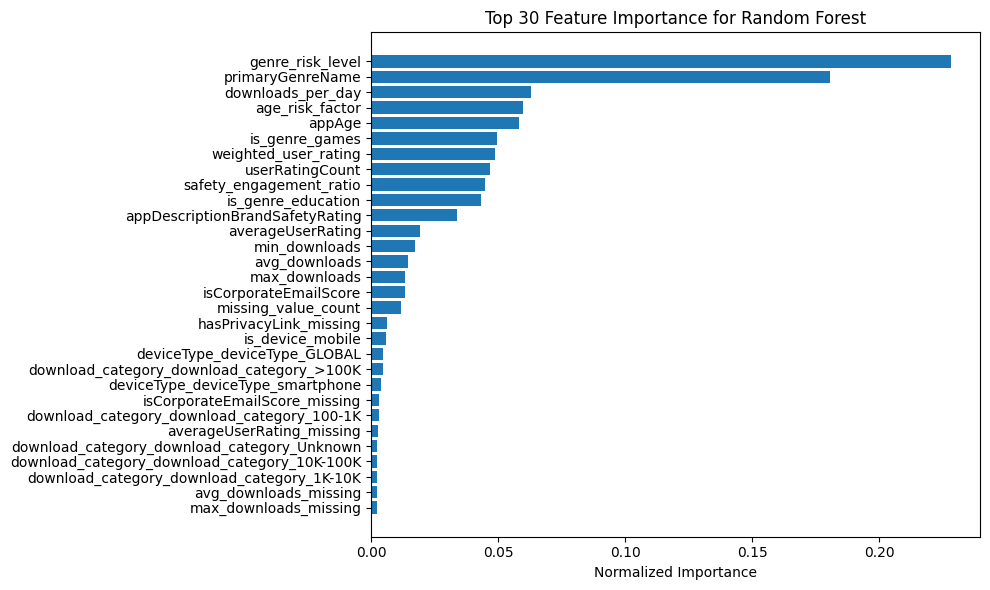


Accuracy:          0.8800
F1 Score (Weight): 0.8848
Recall (Weight):   0.8800
Balanced Accuracy: 0.7093
AUC Score:         0.8877

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1261
         1.0       0.41      0.50      0.45       139

    accuracy                           0.88      1400
   macro avg       0.68      0.71      0.69      1400
weighted avg       0.89      0.88      0.88      1400


LightGBM

Top 30 Features:
                                         Feature  Importance
4                                         appAge    0.173733
25                             downloads_per_day    0.152002
23                               age_risk_factor    0.149758
0                                userRatingCount    0.110311
22                          weighted_user_rating    0.082438
24                       safety_engagement_ratio    0.070863
7                                  min_downloads    0.038148
1 

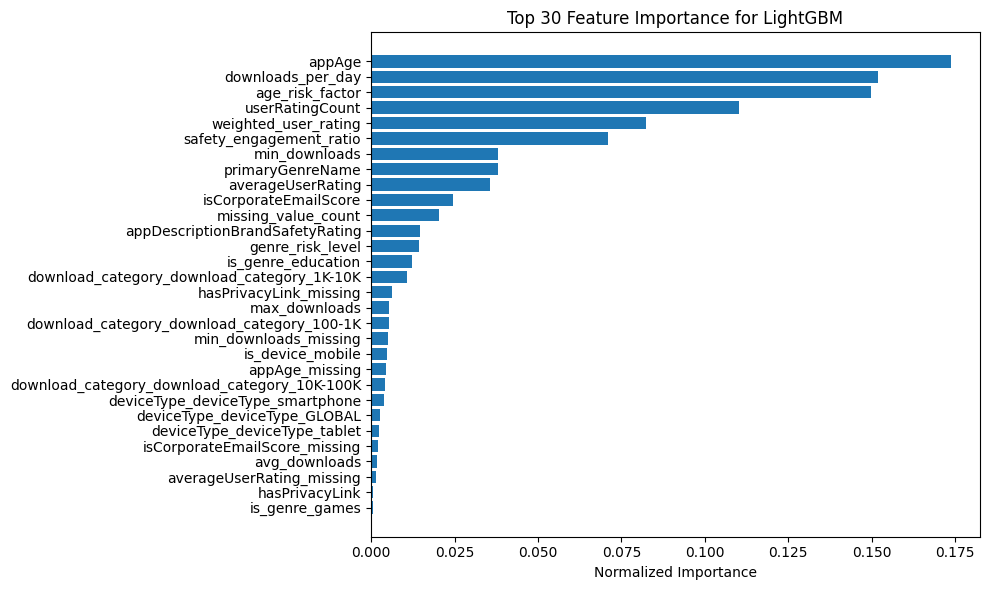


Accuracy:          0.8336
F1 Score (Weight): 0.8594
Recall (Weight):   0.8336
Balanced Accuracy: 0.8116
AUC Score:         0.8800

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      1261
         1.0       0.35      0.78      0.48       139

    accuracy                           0.83      1400
   macro avg       0.66      0.81      0.69      1400
weighted avg       0.91      0.83      0.86      1400


CatBoost

Top 30 Features:
                                         Feature  Importance
20                              genre_risk_level    0.280329
1                               primaryGenreName    0.118009
6                appDescriptionBrandSafetyRating    0.088441
3                          isCorporateEmailScore    0.065469
4                                         appAge    0.038780
26                           missing_value_count    0.038356
5                              averageUserRating    0.036344
22

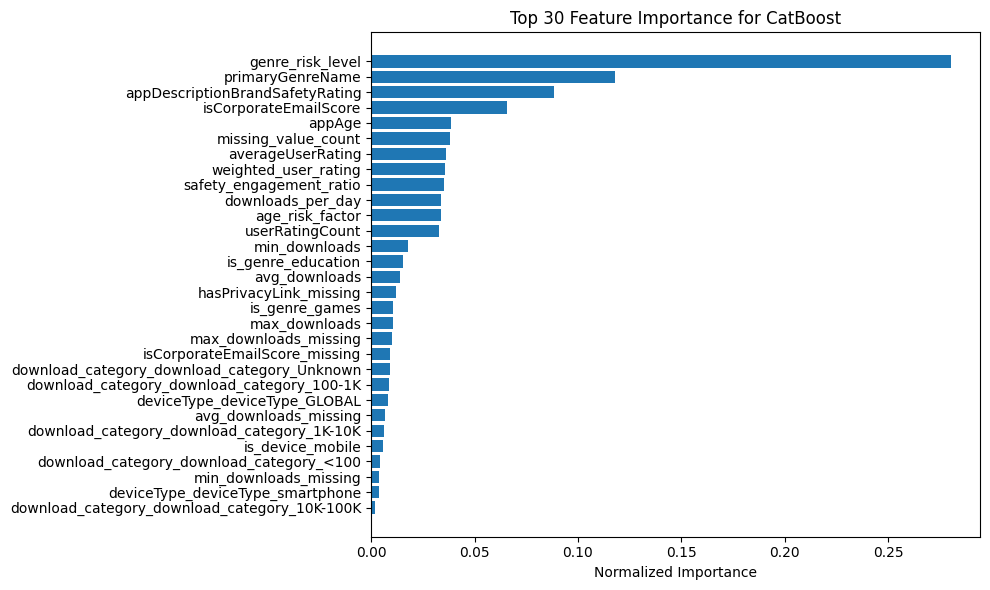


Accuracy:          0.8079
F1 Score (Weight): 0.8419
Recall (Weight):   0.8079
Balanced Accuracy: 0.8357
AUC Score:         0.8965

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      1261
         1.0       0.33      0.87      0.47       139

    accuracy                           0.81      1400
   macro avg       0.65      0.84      0.68      1400
weighted avg       0.92      0.81      0.84      1400


Model Performance Summary (AUC)
CatBoost: 0.896482
Random Forest: 0.887682
LightGBM: 0.880003


In [2700]:
# #? without cat stoppign
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                            balanced_accuracy_score, classification_report,
                            roc_auc_score)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train a model and evaluate its performance with multiple metrics

    Parameters:
    -----------
    model : estimator object
        The model to train and evaluate
    X_train, y_train : array-like
        Training data and labels
    X_val, y_val : array-like
        Validation data and labels
    model_name : str
        Name of the model for display purposes

    Returns:
    --------
    tuple
        Trained model and AUC score
    """
    print("\n" + "="*50)
    print(f"{model_name}")
    print("="*50)

    # Train the model
    model.fit(X_train, y_train)

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        # Normalize importances to sum to 1 for consistent comparison
        normalized_importances = importances / importances.sum()

        # Create DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': normalized_importances
        }).sort_values(by='Importance', ascending=False)

        # Display top 30 features
        print("\nTop 30 Features:")
        print(feature_importance_df.head(30))

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df.head(30)['Feature'],
                feature_importance_df.head(30)['Importance'])
        plt.xlabel('Normalized Importance')
        plt.title(f'Top 30 Feature Importance for {model_name}')
        plt.gca().invert_yaxis()  # Display highest importance at the top
        plt.tight_layout()
        plt.show()

    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probability of positive class

    # Calculate metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="weighted")
    recall = recall_score(y_val, y_pred, average="weighted")
    bal_acc = balanced_accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Print metrics
    print(f'\nAccuracy:          {acc:.4f}')
    print(f'F1 Score (Weight): {f1:.4f}')
    print(f'Recall (Weight):   {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')
    print(f'AUC Score:         {auc:.4f}')

    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    return model, auc


models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
        class_weight='balanced'
    ),

    "LightGBM": LGBMClassifier(
        objective='binary',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=9,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=20,
        n_jobs=-1,
        random_state=42,
        is_unbalance=True,
        verbose=-1
    ),

    "CatBoost": CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=7,
        l2_leaf_reg=3,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        class_weights=[1,9.06],  # Adjust based on class imbalance ratio
        verbose=0
    )
}

# Evaluate all models
results = {}
for name, model in models.items():
    trained_model, auc_score = evaluate_model(model, X_train, y_train, X_val, y_val, name)
    results[name] = {'model': trained_model, 'auc': auc_score}

# Display results summary
print("\n" + "="*50)
print("Model Performance Summary (AUC)")
print("="*50)
for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
    print(f"{name}: {result['auc']:.6f}")

In [2701]:
# # # ? bagged
# from sklearn.ensemble import StackingClassifier, BaggingClassifier, VotingClassifier
# from sklearn.linear_model import LogisticRegression

# # Create a custom wrapper for LightGBM that ignores feature names warning
# class CustomLGBMClassifier(LGBMClassifier):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
        
#     def predict(self, X, **kwargs):
#         return super().predict(X, **kwargs)
        
#     def predict_proba(self, X, **kwargs):
#         return super().predict_proba(X, **kwargs)

# # Calculate class weights based on class distribution
# def calculate_class_weight(y):
#     class_counts = np.bincount(y.astype(int))
#     weights = class_counts.sum() / (class_counts * len(class_counts))
#     return weights[1] / weights[0] if len(weights) > 1 else 1

# class_weight_ratio = calculate_class_weight(y_train)
# print(f"Calculated class weight ratio: {class_weight_ratio:.2f}")

# # Define base models with optimized parameters
# base_models = [
#     ('rf', RandomForestClassifier(
#         n_estimators=200,
#         max_depth=20,
#         min_samples_split=5,
#         min_samples_leaf=2,
#         max_features='sqrt',
#         n_jobs=-1,
#         random_state=42,
#         class_weight='balanced'
#     )),
#     ('lgbm', CustomLGBMClassifier(  # Using custom wrapper instead of LGBMClassifier
#         objective='binary',
#         n_estimators=200,
#         learning_rate=0.05,
#         max_depth=9,
#         num_leaves=63,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_alpha=0.1,
#         reg_lambda=0.1,
#         min_child_samples=20,
#         n_jobs=-1,
#         random_state=42,
#         is_unbalance=True,
#         verbose=-1
#     )),
#     ('catboost', CatBoostClassifier(
#         iterations=200,
#         learning_rate=0.05,
#         depth=7,
#         l2_leaf_reg=3,
#         loss_function='Logloss',
#         eval_metric='AUC',
#         random_seed=42,
#         class_weights=[1, class_weight_ratio],
#         verbose=0
#     ))
# ]

# # 1. Create a Voting Classifier (simplest ensemble)
# voting_clf = VotingClassifier(
#     estimators=base_models,
#     voting='soft',  # Use predicted probabilities
#     n_jobs=-1
# )

# # 2. Create a Stacking Classifier
# meta_model = LogisticRegression(
#     max_iter=1000,
#     class_weight='balanced',  # Note: Should be 'balanced' not 'imbalanced'
#     random_state=42
# )

# stacking_clf = StackingClassifier(
#     estimators=base_models,
#     final_estimator=meta_model,
#     cv=5,  # 5-fold cross-validation for training meta-model
#     stack_method='predict_proba',
#     n_jobs=-1
# )

# # 3. Create a Bagging over Stacking (advanced approach)
# bagged_stack = BaggingClassifier(
#     estimator=stacking_clf,
#     n_estimators=5,  # Number of stacked models to create
#     max_samples=0.9,  # Use 90% of samples for each model
#     bootstrap=True,
#     n_jobs=-1,
#     random_state=42
# )

# # Add these to your models dictionary
# ensemble_models = {
#     "Voting Ensemble": voting_clf,
#     "Stacking Ensemble": stacking_clf,
#     "Bagged Stacking": bagged_stack,
#     # Keep your original models
#     **models
# }

# # Evaluate all models (including ensembles)
# ensemble_results = {}
# for name, model in ensemble_models.items():
#     print(f"\nEvaluating {name}...")
#     trained_model, auc_score = evaluate_model(model, X_train, y_train, X_val, y_val, name)
#     ensemble_results[name] = {'model': trained_model, 'auc': auc_score}

# # Display results summary
# print("\n" + "="*50)
# print("Ensemble Model Performance Summary (AUC)")
# print("="*50)
# for name, result in sorted(ensemble_results.items(), key=lambda x: x[1]['auc'], reverse=True):
#     print(f"{name}: {result['auc']:.6f}")

In [2702]:
# # #? without cat stoppign with class imbalcne shit
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import (accuracy_score, f1_score, recall_score,
#                             balanced_accuracy_score, classification_report,
#                             roc_auc_score)
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
#     """
#     Train a model and evaluate its performance with multiple metrics

#     Parameters:
#     -----------
#     model : estimator object
#         The model to train and evaluate
#     X_train, y_train : array-like
#         Training data and labels
#     X_val, y_val : array-like
#         Validation data and labels
#     model_name : str
#         Name of the model for display purposes

#     Returns:
#     --------
#     tuple
#         Trained model and AUC score
#     """
#     print("\n" + "="*50)
#     print(f"{model_name}")
#     print("="*50)

#     # Train the model
#     model.fit(X_train, y_train)

#     # Get feature importance
#     if hasattr(model, 'feature_importances_'):
#         importances = model.feature_importances_
#         # Normalize importances to sum to 1 for consistent comparison
#         normalized_importances = importances / importances.sum()

#         # Create DataFrame for better visualization
#         feature_importance_df = pd.DataFrame({
#             'Feature': X_train.columns,
#             'Importance': normalized_importances
#         }).sort_values(by='Importance', ascending=False)

#         # Display top 30 features
#         print("\nTop 30 Features:")
#         print(feature_importance_df.head(30))

#         # Plot feature importance
#         plt.figure(figsize=(10, 6))
#         plt.barh(feature_importance_df.head(30)['Feature'],
#                 feature_importance_df.head(30)['Importance'])
#         plt.xlabel('Normalized Importance')
#         plt.title(f'Top 30 Feature Importance for {model_name}')
#         plt.gca().invert_yaxis()  # Display highest importance at the top
#         plt.tight_layout()
#         plt.show()

#     # Make predictions
#     y_pred = model.predict(X_val)
#     y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probability of positive class

#     # Calculate metrics
#     acc = accuracy_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred, average="weighted")
#     recall = recall_score(y_val, y_pred, average="weighted")
#     bal_acc = balanced_accuracy_score(y_val, y_pred)
#     auc = roc_auc_score(y_val, y_pred_proba)

#     # Print metrics
#     print(f'\nAccuracy:          {acc:.4f}')
#     print(f'F1 Score (Weight): {f1:.4f}')
#     print(f'Recall (Weight):   {recall:.4f}')
#     print(f'Balanced Accuracy: {bal_acc:.4f}')
#     print(f'AUC Score:         {auc:.4f}')

#     print("\nClassification Report:")
#     print(classification_report(y_val, y_pred))

#     return model, auc

# # Calculate class weights based on class distribution
# def calculate_class_weight(y):
#     # Count samples in each class
#     class_counts = np.bincount(y.astype(int))
#     # Weight is inversely proportional to class frequency
#     weights = class_counts.sum() / (class_counts * len(class_counts))
#     # Return as a ratio
#     return weights[1] / weights[0] if len(weights) > 1 else 1

# # Get weight ratio for minority class
# class_weight_ratio = calculate_class_weight(y_train)
# print(f"Calculated class weight ratio: {class_weight_ratio:.2f}")

# # Models with consistent class weight handling
# models = {
#     "Random Forest": RandomForestClassifier(
#         n_estimators=200,
#         max_depth=20,
#         min_samples_split=5,
#         min_samples_leaf=2,
#         max_features='sqrt',
#         n_jobs=-1,
#         random_state=42,
#         class_weight='balanced'  # Automatically uses class distribution
#     ),

#     "LightGBM": LGBMClassifier(
#         objective='binary',
#         n_estimators=200,
#         learning_rate=0.05,
#         max_depth=9,
#         num_leaves=63,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_alpha=0.1,
#         reg_lambda=0.1,
#         min_child_samples=20,
#         n_jobs=-1,
#         random_state=42,
#         is_unbalance=True,  # LightGBM's approach to handle imbalance
#         verbose=-1
#     ),

#     "CatBoost": CatBoostClassifier(
#         iterations=200,
#         learning_rate=0.05,
#         depth=7,
#         l2_leaf_reg=9,
#         loss_function='Logloss',
#         eval_metric='AUC',
#         random_seed=42,
#         class_weights=[1, class_weight_ratio],  # Using calculated ratio
#         verbose=0
#     )
# }

# # Evaluate all models
# results = {}
# for name, model in models.items():
#     trained_model, auc_score = evaluate_model(model, X_train, y_train, X_val, y_val, name)
#     results[name] = {'model': trained_model, 'auc': auc_score}

# # Display results summary
# print("\n" + "="*50)
# print("Model Performance Summary (AUC)")
# print("="*50)
# for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
#     print(f"{name}: {result['auc']:.6f}")

Calculated class weight ratio: 9.05

Random Forest

Top 30 Features:
                                         Feature  Importance
20                              genre_risk_level    0.228224
1                               primaryGenreName    0.180412
25                             downloads_per_day    0.062911
23                               age_risk_factor    0.059868
4                                         appAge    0.058214
18                                is_genre_games    0.049670
22                          weighted_user_rating    0.048676
0                                userRatingCount    0.046965
24                       safety_engagement_ratio    0.044664
17                            is_genre_education    0.043141
6                appDescriptionBrandSafetyRating    0.033668
5                              averageUserRating    0.019236
7                                  min_downloads    0.017176
9                                  avg_downloads    0.014688
8               

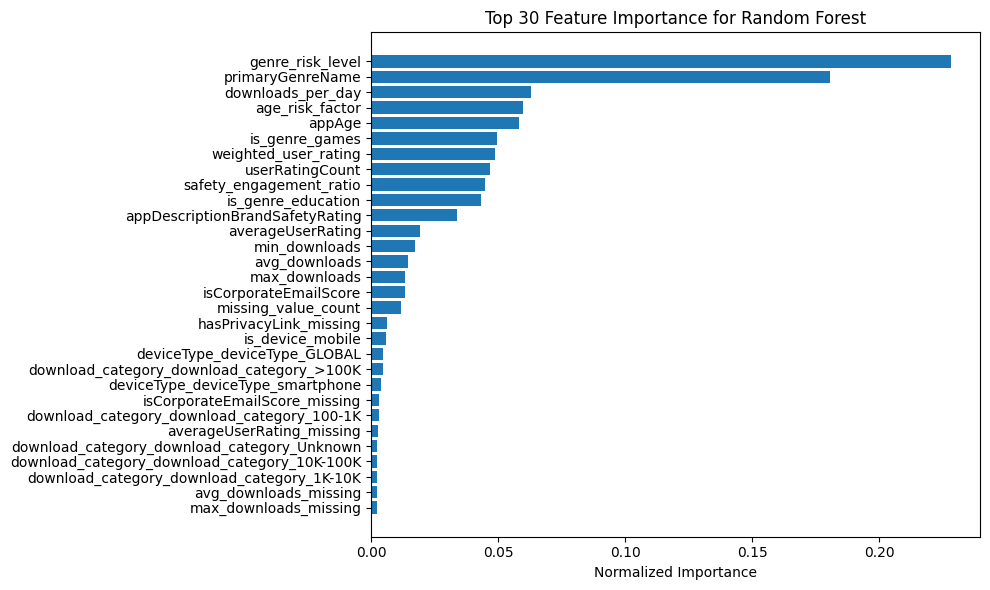


Accuracy:          0.8800
F1 Score (Weight): 0.8848
Recall (Weight):   0.8800
Balanced Accuracy: 0.7093
AUC Score:         0.8877

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1261
         1.0       0.41      0.50      0.45       139

    accuracy                           0.88      1400
   macro avg       0.68      0.71      0.69      1400
weighted avg       0.89      0.88      0.88      1400


LightGBM
Training until validation scores don't improve for 30 rounds
[10]	training's auc: 0.941138	training's binary_logloss: 0.240026	valid_1's auc: 0.882216	valid_1's binary_logloss: 0.260206
[20]	training's auc: 0.949332	training's binary_logloss: 0.241434	valid_1's auc: 0.888147	valid_1's binary_logloss: 0.272508
[30]	training's auc: 0.954411	training's binary_logloss: 0.250972	valid_1's auc: 0.889351	valid_1's binary_logloss: 0.290787
[40]	training's auc: 0.959373	training's binary_logloss: 0.258995	valid_

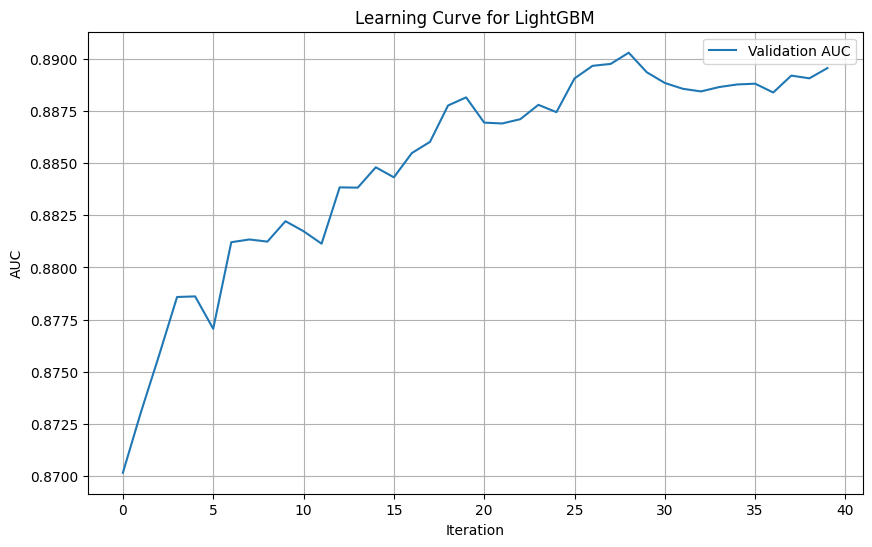


Top 30 Features:
                                         Feature  Importance
25                             downloads_per_day    0.213247
23                               age_risk_factor    0.179321
4                                         appAge    0.124394
22                          weighted_user_rating    0.085622
24                       safety_engagement_ratio    0.079160
1                               primaryGenreName    0.054927
0                                userRatingCount    0.043619
5                              averageUserRating    0.042003
6                appDescriptionBrandSafetyRating    0.024233
3                          isCorporateEmailScore    0.022617
17                            is_genre_education    0.021002
7                                  min_downloads    0.017771
26                           missing_value_count    0.017771
20                              genre_risk_level    0.016155
14                         min_downloads_missing    0.012924
32    

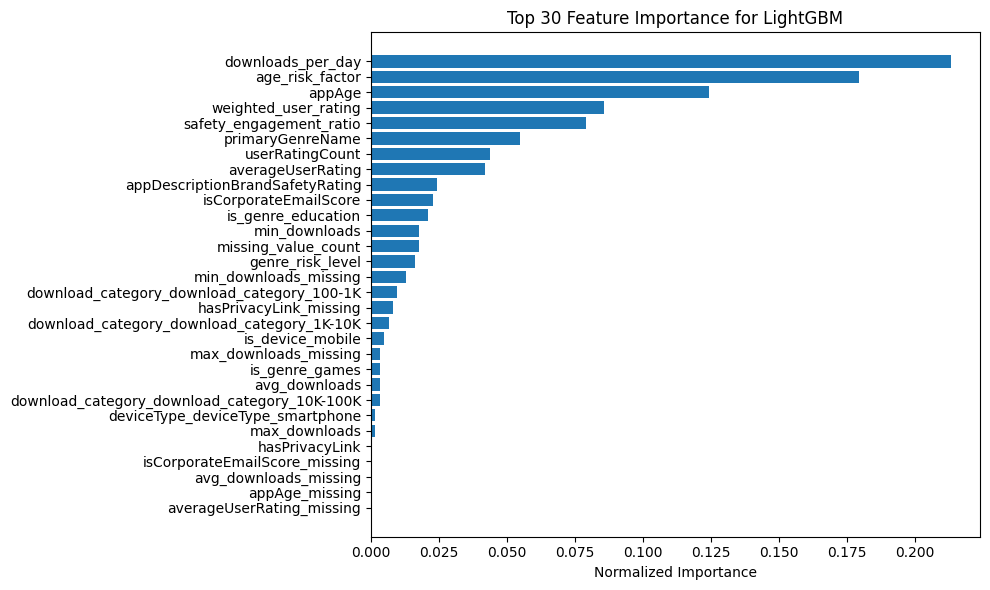


Accuracy:          0.9007
F1 Score (Weight): 0.8537
Recall (Weight):   0.9007
Balanced Accuracy: 0.5000
AUC Score:         0.8822

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      1261
         1.0       0.00      0.00      0.00       139

    accuracy                           0.90      1400
   macro avg       0.45      0.50      0.47      1400
weighted avg       0.81      0.90      0.85      1400


CatBoost
0:	test: 0.8864011	best: 0.8864011 (0)	total: 2.67ms	remaining: 531ms
100:	test: 0.8984562	best: 0.8987129 (86)	total: 213ms	remaining: 209ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8999794613
bestIteration = 127

Shrink model to first 128 iterations.


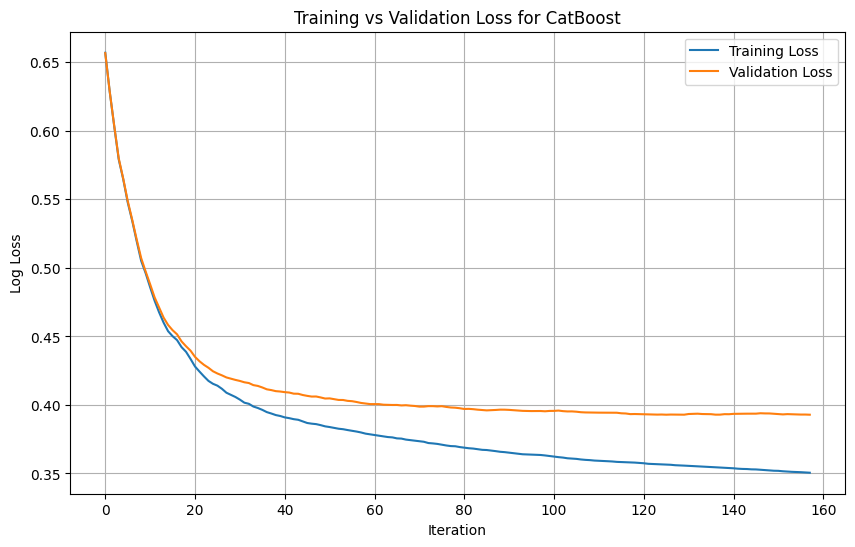


Top 30 Features:
                                         Feature  Importance
20                              genre_risk_level    0.526289
1                               primaryGenreName    0.114008
6                appDescriptionBrandSafetyRating    0.095966
3                          isCorporateEmailScore    0.036000
0                                userRatingCount    0.033293
17                            is_genre_education    0.024027
23                               age_risk_factor    0.017123
25                             downloads_per_day    0.016296
22                          weighted_user_rating    0.016016
9                                  avg_downloads    0.014865
4                                         appAge    0.014207
5                              averageUserRating    0.012242
26                           missing_value_count    0.012036
24                       safety_engagement_ratio    0.011613
7                                  min_downloads    0.010993
37   d

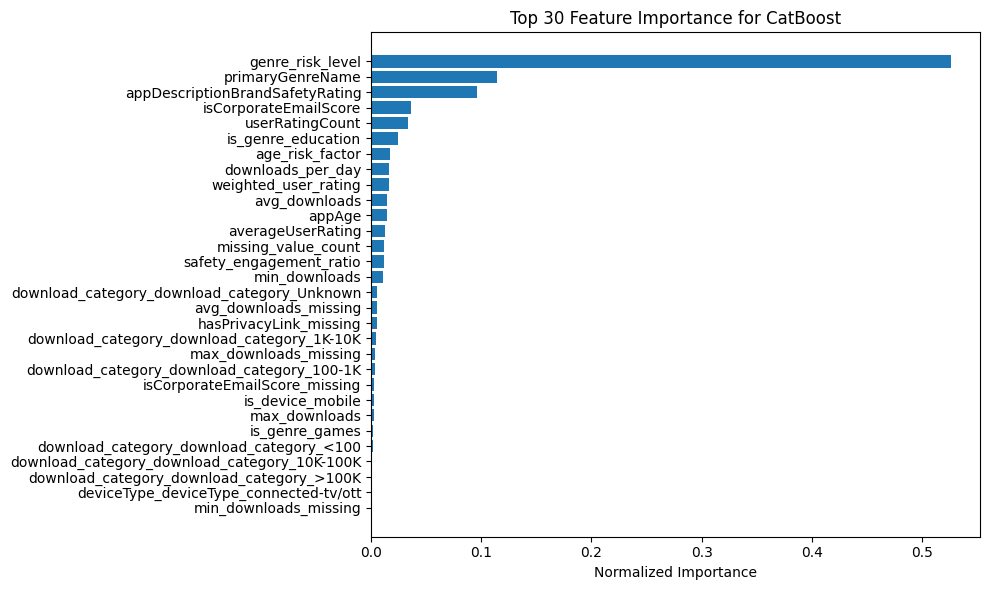


Accuracy:          0.7786
F1 Score (Weight): 0.8206
Recall (Weight):   0.7786
Balanced Accuracy: 0.8387
AUC Score:         0.9000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      1261
         1.0       0.30      0.91      0.45       139

    accuracy                           0.78      1400
   macro avg       0.64      0.84      0.66      1400
weighted avg       0.92      0.78      0.82      1400


Model Performance Summary (AUC)
CatBoost: 0.899979
Random Forest: 0.887682
LightGBM: 0.882216


In [2703]:
# #? CURRENT BEST I THINK
from lightgbm import early_stopping, log_evaluation, record_evaluation
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                            balanced_accuracy_score, classification_report,
                            roc_auc_score)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# train_set, val_set = train_test_split(train, stratify=train['coppaRisk'], test_size=0.2, random_state=42)
# train_piped = pipe.fit_transform(train_set)
# val_piped = pipe.transform(val_set)
# X_train = train_piped.drop(columns=["coppaRisk"])
# y_train = train_piped['coppaRisk']
# X_val= val_piped.drop(columns=["coppaRisk"])
# y_val = val_piped['coppaRisk']

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train a model, evaluate its performance, and plot training vs validation loss if available.
    """
    print("\n" + "="*50)
    print(f"{model_name}")
    print("="*50)
    
    evals_result = {}  # To record evaluation results (for plotting)

    try:
        # Special handling if model supports eval_set (LightGBM, CatBoost)
        if model_name in ["LightGBM", "CatBoost"]:
            if model_name == "LightGBM":
                # Fix for LightGBM - use correct parameters for sklearn API
                eval_set = [(X_train, y_train), (X_val, y_val)]
                model.fit(
                    X_train, y_train,
                    eval_set=eval_set,
                    eval_metric='auc',
                    callbacks=[
                        early_stopping(stopping_rounds=30),
                        log_evaluation(period=10),
                        record_evaluation(evals_result)
                    ]
                )
            elif model_name == "CatBoost":
                model.fit(
                    X_train, y_train,
                    eval_set=(X_val, y_val),
                    verbose=100,
                    # early_stopping_rounds=20
                    early_stopping_rounds=30
                    # early_stopping_rounds=60
                )
                evals_result = model.get_evals_result()
        else:
            # For models without eval_set (like RandomForest)
            model.fit(X_train, y_train)
    except Exception as e:
        print(f"Error during model training: {e}")
        raise

    # Plot learning curves if model supports it
    if model_name in ["LightGBM", "CatBoost"]:
        try:
            if model_name == "LightGBM" and evals_result:
                # Use the evals_result that was populated by record_evaluation
                plt.figure(figsize=(10, 6))
                # Using valid_1 since we provided both train and val sets
                plt.plot(evals_result['valid_1']['auc'], label='Validation AUC')
                plt.xlabel('Iteration')
                plt.ylabel('AUC')
                plt.title(f'Learning Curve for {model_name}')
                plt.legend()
                plt.grid(True)
                plt.show()
            elif model_name == "CatBoost" and evals_result:
                train_loss = evals_result['learn']['Logloss']
                val_loss = evals_result['validation']['Logloss']
                plt.figure(figsize=(10, 6))
                plt.plot(train_loss, label='Training Loss')
                plt.plot(val_loss, label='Validation Loss')
                plt.xlabel('Iteration')
                plt.ylabel('Log Loss')
                plt.title(f'Training vs Validation Loss for {model_name}')
                plt.legend()
                plt.grid(True)
                plt.show()
        except Exception as e:
            print(f"Warning: Could not plot learning curves: {e}")

    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        try:
            importances = model.feature_importances_
            normalized_importances = importances / importances.sum()
            feature_importance_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': normalized_importances
            }).sort_values(by='Importance', ascending=False)

            print("\nTop 30 Features:")
            print(feature_importance_df.head(30))

            plt.figure(figsize=(10, 6))
            plt.barh(feature_importance_df.head(30)['Feature'],
                    feature_importance_df.head(30)['Importance'])
            plt.xlabel('Normalized Importance')
            plt.title(f'Top 30 Feature Importance for {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Warning: Could not calculate or plot feature importance: {e}")

    # Make predictions and calculate metrics
    try:
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Calculate metrics
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")
        recall = recall_score(y_val, y_pred, average="weighted")
        bal_acc = balanced_accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)

        # Print metrics
        print(f'\nAccuracy:          {acc:.4f}')
        print(f'F1 Score (Weight): {f1:.4f}')
        print(f'Recall (Weight):   {recall:.4f}')
        print(f'Balanced Accuracy: {bal_acc:.4f}')
        print(f'AUC Score:         {auc:.4f}')

        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))
    except Exception as e:
        print(f"Error during evaluation: {e}")
        raise

    return model, auc


def calculate_class_weight(y):
    # Count samples in each class
    class_counts = np.bincount(y.astype(int))
    # Weight is inversely proportional to class frequency
    weights = class_counts.sum() / (class_counts * len(class_counts))
    # Return as a ratio
    return weights[1] / weights[0] if len(weights) > 1 else 1

# Get weight ratio for minority class
class_weight_ratio = calculate_class_weight(y_train)
print(f"Calculated class weight ratio: {class_weight_ratio:.2f}")

# Models with consistent class weight handling
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
        class_weight='balanced'  # Automatically uses class distribution
    ),

    "LightGBM": LGBMClassifier(
        objective='binary',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=9,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=20,
        n_jobs=-1,
        random_state=42,
        is_unbalance=True,  # LightGBM's approach to handle imbalance
        verbose=-1
    ),

    "CatBoost": CatBoostClassifier(
        # iterations=200,
        iterations=200,
        learning_rate=0.05,
        # learning_rate=0.04,
        # learning_rate=0.025, ##? better ish 
        # depth=7,
        # depth=5, 
        depth=4, ## ? better ish
        # depth=3, 
        # l2_leaf_reg=3,
        # l2_leaf_reg=6,
        # l2_leaf_reg=7,
        l2_leaf_reg=9, ##? better ish
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        class_weights=[1, class_weight_ratio], 
        verbose=0
    )
}

# Evaluate all models
results = {}
for name, model in models.items():
    try:
        trained_model, auc_score = evaluate_model(model, X_train, y_train, X_val, y_val, name)
        results[name] = {'model': trained_model, 'auc': auc_score}
    except Exception as e:
        print(f"Failed to evaluate {name}: {e}")
        continue

# Display results summary
print("\n" + "="*50)
print("Model Performance Summary (AUC)")
print("="*50)
for name, result in sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True):
    print(f"{name}: {result['auc']:.6f}")

In [2704]:
# # ? RUNNING kfold
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score
# import numpy as np
# import pandas as pd

# train_set = pipe.fit_transform(train_set)
# val_set = pipe.transform(val_set)
# X_train = train_set.drop(columns=["coppaRisk"])
# y_train = train_set['coppaRisk']
# X_val= val_set.drop(columns=["coppaRisk"])
# y_val = val_set['coppaRisk']

# def kfold_cross_validation(model_class, X_train_full, y_train_full, X_val, y_val, n_splits=5, random_state=42, **model_params):
#     """
#     Perform k-fold cross-validation on training data, then evaluate on validation set

#     Parameters:
#     -----------
#     model_class : class
#         The model class to use (e.g., RandomForestClassifier)
#     X_train_full, y_train_full : DataFrame, Series
#         The full training data (before SMOTE)
#     X_val, y_val : DataFrame, Series
#         The validation data for final evaluation
#     n_splits : int, default=5
#         Number of folds for cross-validation
#     random_state : int, default=42
#         Random seed for reproducibility
#     model_params : dict
#         Parameters to pass to the model constructor

#     Returns:
#     --------
#     dict
#         Results including cv_aucs, mean_cv_auc, val_auc, and final_model
#     """
#     # Initialize cross-validation
#     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
#     cv_aucs = []

#     print(f"\n{'='*50}")
#     print(f"K-Fold Cross-Validation for {model_class.__name__}")
#     print(f"{'='*50}")

#     # Perform cross-validation on training data (before SMOTE)
#     for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_full, y_train_full)):
#         # Split data for this fold
#         X_fold_train, X_fold_test = X_train_full.iloc[train_idx], X_train_full.iloc[test_idx]
#         y_fold_train, y_fold_test = y_train_full.iloc[train_idx], y_train_full.iloc[test_idx]

#         # Apply SMOTE only to the training portion of this fold
#         X_fold_train_smote, y_fold_train_smote = my_smote(X_fold_train, y_fold_train)

#         # Initialize and train model
#         model = model_class(**model_params)
#         model.fit(X_fold_train_smote, y_fold_train_smote)

#         # Evaluate on fold's test data
#         y_fold_pred_proba = model.predict_proba(X_fold_test)[:, 1]
#         fold_auc = roc_auc_score(y_fold_test, y_fold_pred_proba)
#         cv_aucs.append(fold_auc)

#         print(f"Fold {fold+1}/{n_splits} - AUC: {fold_auc:.6f}")

#     # Display cross-validation results
#     mean_cv_auc = np.mean(cv_aucs)
#     std_cv_auc = np.std(cv_aucs)
#     print(f"\nCross-Validation - Mean AUC: {mean_cv_auc:.6f} (±{std_cv_auc:.6f})")

#     # Train final model on the entire SMOTE'd training data
#     X_train_smote, y_train_smote = my_smote(X_train_full, y_train_full)
#     final_model = model_class(**model_params)
#     final_model.fit(X_train_smote, y_train_smote)

#     # Evaluate on the separate validation set
#     val_pred_proba = final_model.predict_proba(X_val)[:, 1]
#     val_auc = roc_auc_score(y_val, val_pred_proba)
#     print(f"Validation Set - AUC: {val_auc:.6f}")

#     # Return results
#     return {
#         'cv_aucs': cv_aucs,
#         'mean_cv_auc': mean_cv_auc,
#         'std_cv_auc': std_cv_auc,
#         'val_auc': val_auc,
#         'final_model': final_model
#     }

# # Run k-fold CV for each model
# models_to_evaluate = {
#     'Random Forest': (RandomForestClassifier, {
#         'n_estimators': 200,
#         'max_depth': 15,
#         'min_samples_split': 5,
#         'min_samples_leaf': 2,
#         'max_features': 'sqrt',
#         'n_jobs': -1,
#         'random_state': 42,
#         'class_weight': 'balanced'
#     }),

#     'LightGBM': (LGBMClassifier, {
#         'objective': 'binary',
#         'n_estimators': 200,
#         'learning_rate': 0.05,
#         'max_depth': 9,
#         'num_leaves': 63,
#         'n_jobs': -1,
#         'random_state': 42,
#         'is_unbalance': True,
#         'verbose': -1
#     }),

#     'CatBoost': (CatBoostClassifier, {
#         'iterations': 200,
#         'learning_rate': 0.05,
#         'depth': 7,
#         'l2_leaf_reg': 3,
#         'random_seed': 42,
#         'class_weights': [1, 9.06],
#         'verbose': 0
#     })
# }

# # Run cross-validation for each model
# cv_results = {}
# for model_name, (model_class, params) in models_to_evaluate.items():
#     cv_results[model_name] = kfold_cross_validation(
#         model_class,
#         X_train,
#         y_train,
#         X_val,
#         y_val,
#         n_splits=5,
#         **params
#     )

# # Print summary of results
# print("\n" + "="*50)
# print("Model Performance Summary")
# print("="*50)
# print(f"{'Model':<15} {'CV AUC':<15} {'Validation AUC':<15}")
# print("-"*50)
# for model_name, results in cv_results.items():
#     print(f"{model_name:<15} {results['mean_cv_auc']:.6f} (±{results['std_cv_auc']:.6f}) {results['val_auc']:.6f}")

In [2705]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold # Use StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation, record_evaluation # Import necessary callbacks
# from catboost import CatBoostClassifier
# from sklearn.metrics import (accuracy_score, f1_score, recall_score,
#                             balanced_accuracy_score, classification_report,
#                             roc_auc_score)
# # Assuming your custom pipeline classes (FeatureCleaner, FeatureCreator, etc.)
# # and the Pipeline object 'pipe' are defined above this code.
# # Also assume you have your FULL raw training data in X_raw and y_raw pandas DataFrames/Series
# # If you previously split into train_set/val_set, combine them back for K-Fold

# # --- INSTEAD, DEFINE X_raw and y_raw FROM THE ORIGINAL 'train' DataFrame ---
# X_raw = train.drop(columns=['coppaRisk'])  # All original features
# y_raw = train['coppaRisk']                # The original target column


# # --- Your existing evaluate_model function (with potential modification for plotting) ---
# def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, fold_num=None, plot_curves=True, plot_importance=True): # Added fold_num and plot flags
#     """
#     Train a model, evaluate its performance, and optionally plot curves/importance.
#     """
#     fold_str = f" Fold {fold_num}" if fold_num is not None else ""
#     print("\n" + "="*50)
#     print(f"{model_name}{fold_str}")
#     print("="*50)

#     evals_result = {}

#     try:
#         if model_name.startswith("LightGBM"): # Check name prefix
#             eval_set = [(X_train, y_train), (X_val, y_val)]
#             model.fit(
#                 X_train, y_train,
#                 eval_set=eval_set,
#                 eval_metric='auc',
#                 callbacks=[
#                     early_stopping(stopping_rounds=30),
#                     log_evaluation(period=100), # Log less often in KFold
#                     record_evaluation(evals_result)
#                 ]
#             )
#         elif model_name.startswith("CatBoost"): # Check name prefix
#             model.fit(
#                 X_train, y_train,
#                 eval_set=(X_val, y_val),
#                 verbose=0, # Suppress verbose output within fold loop
#                 early_stopping_rounds=30
#             )
#             evals_result = model.get_evals_result()
#         else: # RandomForest
#             model.fit(X_train, y_train)
#     except Exception as e:
#         print(f"Error during model training for {model_name}{fold_str}: {e}")
#         raise # Re-raise the exception to handle it in the K-Fold loop

#     # --- Plotting (Conditional) ---
#     if plot_curves and model_name.startswith("CatBoost") and evals_result:
#          try:
#              train_loss = evals_result['learn']['Logloss']
#              val_loss = evals_result['validation']['Logloss']
#              plt.figure(figsize=(8, 5)) # Smaller plots for folds
#              plt.plot(train_loss, label='Training Loss')
#              plt.plot(val_loss, label='Validation Loss')
#              plt.xlabel('Iteration')
#              plt.ylabel('Log Loss')
#              plt.title(f'Loss Curve for {model_name}{fold_str}')
#              plt.legend()
#              plt.grid(True)
#              plt.show()
#          except Exception as e:
#              print(f"Warning: Could not plot learning curves for {model_name}{fold_str}: {e}")
#     # Add similar conditional plotting for LGBM AUC if desired

#     # --- Feature Importance (Conditional) ---
#     if plot_importance and hasattr(model, 'feature_importances_'):
#         try:
#             importances = model.feature_importances_
#             # Check if X_train is pandas DataFrame to get column names
#             if isinstance(X_train, pd.DataFrame):
#                  feature_names = X_train.columns
#             else: # Handle numpy array case if needed
#                  feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

#             normalized_importances = importances / importances.sum()
#             feature_importance_df = pd.DataFrame({
#                 'Feature': feature_names,
#                 'Importance': normalized_importances
#             }).sort_values(by='Importance', ascending=False)

#             print(f"\nTop 15 Features ({model_name}{fold_str}):") # Show fewer features per fold
#             print(feature_importance_df.head(15))

#             # Optional: Plot only for first fold or aggregate later
#             # plt.figure(figsize=(8, 5))
#             # plt.barh(feature_importance_df.head(15)['Feature'], ...)
#             # plt.show()
#         except Exception as e:
#              print(f"Warning: Could not calculate/plot feature importance for {model_name}{fold_str}: {e}")

#     # --- Evaluation Metrics ---
#     auc = np.nan # Default in case of error
#     try:
#         y_pred = model.predict(X_val)
#         y_pred_proba = model.predict_proba(X_val)[:, 1]

#         acc = accuracy_score(y_val, y_pred)
#         f1 = f1_score(y_val, y_pred, average="weighted")
#         recall = recall_score(y_val, y_pred, average="weighted")
#         bal_acc = balanced_accuracy_score(y_val, y_pred)
#         auc = roc_auc_score(y_val, y_pred_proba)

#         print(f'\nAccuracy:          {acc:.4f}')
#         print(f'F1 Score (Weight): {f1:.4f}')
#         print(f'Recall (Weight):   {recall:.4f}')
#         print(f'Balanced Accuracy: {bal_acc:.4f}')
#         print(f'AUC Score:         {auc:.4f}')

#         # Optional: Reduce classification report verbosity in KFold
#         # print("\nClassification Report:")
#         # print(classification_report(y_val, y_pred, digits=4))

#     except Exception as e:
#         print(f"Error during evaluation for {model_name}{fold_str}: {e}")
#         # Keep auc as np.nan

#     return model, auc # Return model and AUC score

# # --- Your existing calculate_class_weight function ---
# def calculate_class_weight(y):
#     class_counts = np.bincount(y.astype(int))
#     # Prevent division by zero if a class is missing in a small fold
#     if len(class_counts) < 2: return 1
#     if 0 in class_counts: return 1 # Or handle appropriately
#     weights = class_counts.sum() / (class_counts * len(class_counts))
#     return weights[1] / weights[0]

# # --- K-Fold Cross-Validation Setup ---
# N_SPLITS = 5 # Number of folds (e.g., 5 or 10)
# kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# # Dictionary to store results for each model
# cv_results = {}
# # Optional: Dictionary for out-of-fold predictions
# oof_predictions = {}

# # --- Base model definitions (use parameters from your best run) ---
# # It's crucial models are re-initialized or deep-copied each fold if they have state
# # Note: Parameters for RF and LGBM might need re-evaluation via CV
# models_base = {
#      "Random Forest": RandomForestClassifier(
#         n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2,
#         max_features='sqrt', n_jobs=-1, random_state=42, class_weight='balanced'
#     ),
#     "LightGBM": LGBMClassifier(
#         objective='binary', n_estimators=200, learning_rate=0.05, max_depth=9,
#         num_leaves=63, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
#         reg_lambda=0.1, min_child_samples=20, n_jobs=-1, random_state=42,
#         is_unbalance=True, verbose=-1 # Or use scale_pos_weight
#     ),
#     "CatBoost": CatBoostClassifier(
#         iterations=200, learning_rate=0.05, depth=4, l2_leaf_reg=9,
#         loss_function='Logloss', eval_metric='AUC', random_seed=42,
#         # Class weights will be set per fold
#         verbose=0 # Keep it quiet during folds
#     )
# }

# # Assuming X_raw and y_raw contain your FULL raw training dataset
# if 'X_raw' not in locals() or 'y_raw' not in locals():
#      raise NameError("Please ensure your full raw training data is loaded into X_raw and y_raw before running K-Fold")

# # --- K-Fold Loop ---
# for model_name, base_model in models_base.items():
#     print(f"\n======= Running K-Fold Cross-Validation for {model_name} =======")
#     fold_auc_scores = []
#     # Initialize OOF predictions array for this model
#     oof_preds_model = np.zeros(len(X_raw))
#     # Use a boolean mask to track which indices have predictions
#     oof_indices_mask = np.zeros(len(X_raw), dtype=bool)


#     # --- Loop through folds ---
#     for fold, (train_index, val_index) in enumerate(kfold.split(X_raw, y_raw)):
#         fold_num = fold + 1
#         print(f"\n--- Processing Fold {fold_num}/{N_SPLITS} ---")

#         # 1. Split RAW data for the current fold
#         X_train_fold_raw, X_val_fold_raw = X_raw.iloc[train_index], X_raw.iloc[val_index]
#         y_train_fold, y_val_fold = y_raw.iloc[train_index], y_raw.iloc[val_index]

#         # 2. Fit the pipeline on the RAW training data for THIS fold
#         # (Pipeline state is reset by fit, safe for standard sklearn/custom transformers)
#         print(f"  Fitting pipeline on {len(X_train_fold_raw)} training samples...")
#         pipe.fit(X_train_fold_raw, y_train_fold)
        
#         # ================== DEBUGGING BLOCK ==================
#         print("\n  --- Debugging Transformation Steps ---")
#         current_X_debug = X_train_fold_raw.copy() # Use a separate variable for debugging transform
#         transform_error = False
#         problematic_input_to_step = None # Define outside the loop

#         for name, step in pipe.steps:
#             print(f"  Attempting to transform with step: {name}...")
#             input_before_step = current_X_debug.copy() # Store data *before* this step transforms it
#             try:
#                 # Apply transform of the step (already fitted by pipe.fit above)
#                 current_X_debug = step.transform(current_X_debug)
#                 print(f"    Step '{name}' successful. Output shape: {current_X_debug.shape}")
#             except Exception as e:
#                 print(f"\n  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
#                 print(f"  ERROR occurred during transform at step: '{name}'")
#                 print(f"  Error message: {e}")
#                 print(f"  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
#                 problematic_step_name = name
#                 problematic_input_to_step = input_before_step # Capture the input that caused error
#                 transform_error = True # Flag that an error occurred
#                 break # Stop processing steps for this fold

#         if transform_error:
#             # Print details about the input that caused the error
#             if problematic_input_to_step is not None:
#                 print("  --- Input Data to Failing Step ('problematic_input_to_step') ---")
#                 print(f"  Input Shape: {problematic_input_to_step.shape}")
#                 print("  Input Dtypes:\n", problematic_input_to_step.dtypes)
#                 print("\n  Input Data Sample (Head):\n", problematic_input_to_step.head())
#                 object_cols = problematic_input_to_step.select_dtypes(include='object').columns
#                 if not object_cols.empty:
#                      print(f"\n  Object columns in input: {list(object_cols)}")
#                      for col in object_cols[:5]:
#                          try:
#                              unique_vals = problematic_input_to_step[col].unique()
#                              print(f"    Unique values in '{col}' (sample): {unique_vals[:10]}")
#                          except TypeError:
#                              print(f"    Could not get unique values for '{col}' (likely mixed types).")
#                 else:
#                      print("\n  No object columns found in input to failing step.")
#             print("  Skipping model training & evaluation for this fold due to transform error.")
#             fold_auc_scores.append(np.nan) # Record failure for this fold
#             continue # Skip to the next fold
#         else:
#              print("  --- All transformation steps successful ---")
#              # The final transformed data is in current_X_debug
#              X_train_fold_processed = current_X_debug
#              # Still need to transform validation data
#              try:
#                  print("  Transforming validation data...")
#                  X_val_fold_processed = pipe.transform(X_val_fold_raw)
#                  print(f"  Processed validation shape: {X_val_fold_processed.shape}")
#              except Exception as e:
#                   print(f"  ERROR transforming validation data in Fold {fold_num} after successful train transform: {e}")
#                   print("  Skipping model training & evaluation for this fold.")
#                   fold_auc_scores.append(np.nan) # Record failure for this fold
#                   continue # Skip to the next fold

#         # ================== END DEBUGGING BLOCK ==================

#         # 3. Transform the fold's training and validation data
#         print("  Transforming data...")
#         X_train_fold_processed = pipe.transform(X_train_fold_raw)
#         X_val_fold_processed = pipe.transform(X_val_fold_raw)
#         print(f"  Processed training shape: {X_train_fold_processed.shape}")
#         print(f"  Processed validation shape: {X_val_fold_processed.shape}")


#         # 4. Prepare model instance for the fold (essential!)
#         # Create a fresh instance to avoid state leakage across folds
#         # Note: directly using base_model would refit the same object. Use clone or deepcopy if needed,
#         # or just re-instantiate using the parameters like below.
#         if model_name == "CatBoost":
#              fold_class_weight_ratio = calculate_class_weight(y_train_fold)
#              print(f"  Fold {fold_num} class weight ratio: {fold_class_weight_ratio:.2f}")
#              current_model = CatBoostClassifier(
#                  iterations=base_model.get_params()['iterations'], learning_rate=base_model.get_params()['learning_rate'],
#                  depth=base_model.get_params()['depth'], l2_leaf_reg=base_model.get_params()['l2_leaf_reg'],
#                  loss_function=base_model.get_params()['loss_function'], eval_metric=base_model.get_params()['eval_metric'],
#                  random_seed=base_model.get_params()['random_seed'] + fold_num, # Vary seed per fold slightly
#                  class_weights=[1, fold_class_weight_ratio], verbose=0
#              )
#         elif model_name == "LightGBM":
#              # Re-instantiate LightGBM
#              current_model = LGBMClassifier(**base_model.get_params())
#              # If using scale_pos_weight instead of is_unbalance=True:
#              # fold_class_weight_ratio = calculate_class_weight(y_train_fold)
#              # current_model.set_params(scale_pos_weight=fold_class_weight_ratio, is_unbalance=False, random_state=42+fold_num)
#              current_model.set_params(random_state=42+fold_num) # Vary seed
#         elif model_name == "Random Forest":
#              # Re-instantiate RandomForest
#              current_model = RandomForestClassifier(**base_model.get_params())
#              current_model.set_params(random_state=42+fold_num) # Vary seed
#         else:
#              # Handle other models if added
#              import copy
#              current_model = copy.deepcopy(base_model) # Generic fallback if re-instantiation is hard


#         # 5. Evaluate the model on the current fold
#         try:
#             # Disable plotting for individual folds to avoid clutter
#             trained_model, fold_auc = evaluate_model(
#                 current_model,
#                 X_train_fold_processed, y_train_fold,
#                 X_val_fold_processed, y_val_fold,
#                 model_name, # Pass base name
#                 fold_num=fold_num, # Pass fold number
#                 plot_curves=False, # Disable curve plotting per fold
#                 plot_importance= (fold_num == 1) # Plot importance only for the first fold
#             )

#             if fold_auc is not np.nan:
#                  fold_auc_scores.append(fold_auc)
#                  # Store OOF predictions
#                  oof_preds_model[val_index] = trained_model.predict_proba(X_val_fold_processed)[:, 1]
#                  oof_indices_mask[val_index] = True # Mark these indices as having OOF predictions
#             else:
#                  print(f"  Skipping results for Fold {fold_num} due to evaluation error.")

#         except Exception as e:
#             print(f"  Failed to train/evaluate {model_name} on Fold {fold_num}: {e}")
#             fold_auc_scores.append(np.nan) # Record failure

#     # --- Aggregate results for the model ---
#     if fold_auc_scores: # Check if list is not empty
#          mean_auc = np.nanmean(fold_auc_scores)
#          std_auc = np.nanstd(fold_auc_scores)
#          print(f"\n----- K-Fold AUC Results for {model_name} -----")
#          print(f"  Fold AUCs: {[f'{auc:.4f}' if not np.isnan(auc) else 'NaN' for auc in fold_auc_scores]}")
#          print(f"  Mean AUC: {mean_auc:.4f}")
#          print(f"  Std Dev AUC: {std_auc:.4f}")
#          cv_results[model_name] = {'mean_auc': mean_auc, 'std_auc': std_auc, 'fold_aucs': fold_auc_scores}
#          # Store OOF predictions for this model
#          # Create a pandas Series aligned with the original index
#          oof_series = pd.Series(oof_preds_model[oof_indices_mask], index=X_raw.index[oof_indices_mask], name=f"{model_name}_oof_pred")
#          oof_predictions[model_name] = oof_series

#     else:
#          print(f"\n----- No successful folds completed for {model_name} -----")
#          cv_results[model_name] = {'mean_auc': np.nan, 'std_auc': np.nan, 'fold_aucs': []}


# # --- Final Summary ---
# print("\n" + "="*60)
# print("Overall K-Fold Model Performance Summary (Mean AUC)")
# print("="*60)
# # Sort results by mean AUC, handle NaNs
# sorted_results = sorted(cv_results.items(), key=lambda x: x[1]['mean_auc'] if not np.isnan(x[1]['mean_auc']) else -1, reverse=True)
# for name, result in sorted_results:
#     if not np.isnan(result['mean_auc']):
#         print(f"{name}: {result['mean_auc']:.6f} +/- {result['std_auc']:.6f}")
#     else:
#         print(f"{name}: Failed to train/evaluate.")

# # --- Optional: Analyze OOF Predictions ---
# # You can now concatenate the OOF prediction Series/DataFrames if needed
# # all_oof_preds = pd.concat(oof_predictions.values(), axis=1)
# # print("\nOut-of-Fold Predictions Sample:")
# # print(all_oof_preds.head())
# # You can calculate the overall AUC on the OOF predictions vs y_raw
# # overall_oof_auc = roc_auc_score(y_raw[oof_indices_mask], oof_preds_model[oof_indices_mask]) # For the last model run
# # print(f"\nOverall OOF AUC for last model ({model_name}): {overall_oof_auc:.6f}")

## 5. Submission

In [2706]:
cols_to_drop_based_on_eda = ['adSpent',"developerCountry", "countryCode", "mfaRating"]

pipe_submit = Pipeline([
                #  ("duplicate_remover", DuplicateRemover(verbose=True)), # Added verbose=True for clarity
                 ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
                 ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                ("feature_creator", FeatureCreator()),
                 ("feature_transformator", FeatureTransformator()),
                 ("feature_scaler", FeatureScaler()), #? not final if gonna be used
                 ("feature_encoder", FeatureEncoder()),
                 ])


In [2707]:
# catboost_submission = CatBoostClassifier(
#         iterations=200,
#         # iterations=400,
#         learning_rate=0.05,
#         depth=7,
#         l2_leaf_reg=3,
#         loss_function='Logloss',
#         eval_metric='AUC',
#         random_seed=42,
#         class_weights=[1,9.06],
#         verbose=0
#     )

# # Save the IDs before processing
# test_ids = test['ID'].copy()
# test_features = test.drop(columns=['ID'])
# test_features['coppaRisk'] = False  # or 0, depending on your target type
# # First fit_transform the pipeline on training data
# train_transformed = pipe_submit.fit_transform(train_original)

# # Then transform test data using the fitted pipeline
# test_transformed = pipe_submit.transform(test_features)

# # Train your model on the transformed training data
# X_train_submit = train_transformed.drop(columns=["coppaRisk"])
# y_train_submit = train_transformed['coppaRisk']
# X_train_submit, y_train_submit = my_smote(X_train_submit, y_train_submit)
# catboost_submission.fit(X_train_submit, y_train_submit)

# # Make predictions on the transformed test data
# predictions = catboost_submission.predict_proba(test_transformed)[:, 1]  # Probabilities for positive class

# # Create submission with correct IDs
# submission = pd.DataFrame({
#     'ID': test_ids,
#     'coppaRisk': predictions
# })

# submission.to_csv('submission.csv', index=False)

FeatureDropper initialized to drop: ['adSpent', 'countryCode', 'developerCountry', 'mfaRating']
FeatureDropper: Dropping columns: ['adSpent', 'countryCode', 'developerCountry', 'mfaRating']

ANALYZING IMPUTATION STRATEGIES

userRatingCount: No missing values

primaryGenreName: No missing values

deviceType: No missing values

hasPrivacyLink: 590 missing values (10.54%)
  - Data type: object
  - Value distribution (top 3):
      True: 88.57%
      False: 0.89%
  - Recommendation: Most frequent imputation (dominant category)

hasTermsOfServiceLink: HIGH MISSING DATA (66.12%)
  - Recommendation: Drop column

hasTermsOfServiceLinkRating: HIGH MISSING DATA (66.12%)
  - Recommendation: Drop column

isCorporateEmailScore: 894 missing values (15.96%)
  - Data type: float64
  - Mean: 45.6292
  - Median: 0.0000
  - Mode: 0.0
  - Skewness: 0.1569
  - Recommendation: Mean imputation (normal distribution)

appAge: 38 missing values (0.68%)
  - Data type: float64
  - Mean: 57.0968
  - Median: 52.716

  - Mean: 2.4938
  - Median: 3.0000
  - Mode: 4.0
  - Skewness: -0.3485
  - Recommendation: Mean imputation (normal distribution)

appContentBrandSafetyRating: HIGH MISSING DATA (88.16%)
  - Recommendation: Drop column

appDescriptionBrandSafetyRating: No missing values

coppaRisk: No missing values

min_downloads: 1735 missing values (30.98%)
  - Data type: float64
  - Mean: 7032638.2168
  - Median: 500.0000
  - Mode: 100.0
  - Skewness: 43.4587
  - Recommendation: Median imputation (skewed distribution)

max_downloads: 1735 missing values (30.98%)
  - Data type: float64
  - Mean: 15406279.2792
  - Median: 1000.0000
  - Mode: 500.0
  - Skewness: 40.3118
  - Recommendation: Median imputation (skewed distribution)

avg_downloads: 1735 missing values (30.98%)
  - Data type: float64
  - Mean: 11219458.7480
  - Median: 750.0000
  - Mode: 300.0
  - Skewness: 41.8252
  - Recommendation: Median imputation (skewed distribution)

download_category: No missing values

SUMMARY OF RECOMMENDATIONS


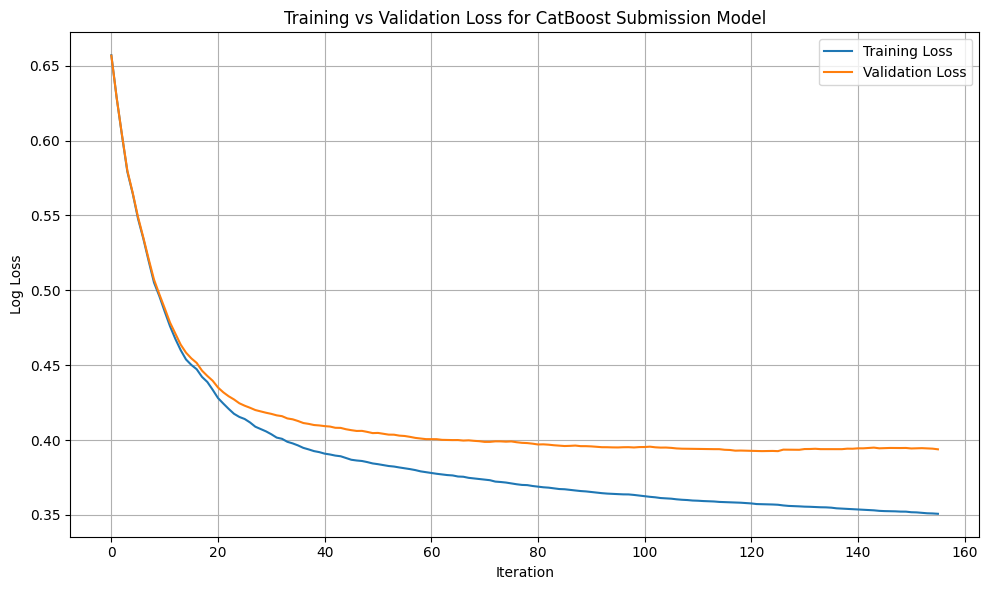

FeatureDropper: Dropping columns: ['adSpent', 'countryCode', 'developerCountry', 'mfaRating']
  - Created original genre features: is_genre_education, is_genre_games, is_genre_stickers, genre_risk_level
  - Created original device flag: is_device_mobile
  - Created original interaction: weighted_user_rating
  - Created original app age features: age_risk_factor
  - Created original safety_engagement_ratio
  - Gemini Added: downloads_per_day
  - Gemini Added: missing_value_count from 7 indicators
FeatureCreator transform finished. Added/Modified columns: ['is_genre_education', 'is_genre_games', 'is_genre_stickers', 'genre_risk_level', 'is_device_mobile', 'weighted_user_rating', 'age_risk_factor', 'safety_engagement_ratio', 'downloads_per_day', 'missing_value_count']


In [2709]:
# First, create a train/validation split before preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                           balanced_accuracy_score, classification_report,
                           roc_auc_score)

# Save the IDs before processing
test_ids = test['ID'].copy()
test_features = test.drop(columns=['ID'])

# Split the original training data
train_set, val_set = train_test_split(
    train_original,
    stratify=train_original['coppaRisk'],
    test_size=0.2,
    random_state=42
)

# Now fit the pipeline on training only and transform both sets
train_piped = pipe_submit.fit_transform(train_set)
val_piped = pipe_submit.transform(val_set)

# Extract features and target for training and validation
X_train_submit = train_piped.drop(columns=["coppaRisk"])
y_train_submit = train_piped['coppaRisk']
X_val_submit = val_piped.drop(columns=["coppaRisk"])
y_val_submit = val_piped['coppaRisk']

# Calculate class weight ratio for the final model
def calculate_class_weight(y):
    # Count samples in each class
    class_counts = np.bincount(y.astype(int))
    # Weight is inversely proportional to class frequency
    weights = class_counts.sum() / (class_counts * len(class_counts))
    # Return as a ratio
    return weights[1] / weights[0] if len(weights) > 1 else 1

# Calculate the class weight ratio
class_weight_ratio = calculate_class_weight(y_train_submit)
print(f"Calculated class weight ratio for submission: {class_weight_ratio:.2f}")

# Create CatBoost model with your preferred parameters
catboost_submission = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=9,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    class_weights=[1, class_weight_ratio],
    verbose=0
)

# Fit the model with early stopping
catboost_submission.fit(
    X_train_submit,
    y_train_submit,
    eval_set=(X_val_submit, y_val_submit),
    early_stopping_rounds=30,
    verbose=100
)

# Get evaluation results for plotting
evals_result = catboost_submission.get_evals_result()

# Calculate and print classification metrics
y_val_pred = catboost_submission.predict(X_val_submit)
y_val_pred_proba = catboost_submission.predict_proba(X_val_submit)[:, 1]

# Calculate metrics
acc = accuracy_score(y_val_submit, y_val_pred)
f1 = f1_score(y_val_submit, y_val_pred, average="weighted")
recall = recall_score(y_val_submit, y_val_pred, average="weighted")
bal_acc = balanced_accuracy_score(y_val_submit, y_val_pred)
auc = roc_auc_score(y_val_submit, y_val_pred_proba)

# Print metrics
print("\n" + "="*50)
print("Submission Model Performance on Validation Set")
print("="*50)
print(f'Accuracy:          {acc:.4f}')
print(f'F1 Score (Weight): {f1:.4f}')
print(f'Recall (Weight):   {recall:.4f}')
print(f'Balanced Accuracy: {bal_acc:.4f}')
print(f'AUC Score:         {auc:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_submit, y_val_pred))

# Plot training vs validation loss
if evals_result:
    train_loss = evals_result['learn']['Logloss']
    val_loss = evals_result['validation']['Logloss']
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title('Training vs Validation Loss for CatBoost Submission Model')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('catboost_learning_curve.png')  # Save the figure to a file
    plt.show()  # Also display it if you're in a notebook

# Transform the test data
test_features['coppaRisk'] = False  # or 0, depending on your target type
test_transformed = pipe_submit.transform(test_features)

# Make predictions on the transformed test data
predictions = catboost_submission.predict_proba(test_transformed)[:, 1]

# Create submission with correct IDs
submission = pd.DataFrame({
    'ID': test_ids,
    'coppaRisk': predictions
})

submission.to_csv('submission.csv', index=False)

In [2710]:
# import pandas as pd
# import numpy as np
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split
# def calculate_class_weight(y):
#     """Calculates the weight ratio for the positive class."""
#     # Ensure y is integer type for bincount
#     y_int = y.astype(int)
#     class_counts = np.bincount(y_int)
#     # Check for edge cases (only one class)
#     if len(class_counts) < 2 or 0 in class_counts:
#         print("Warning: Only one class present or missing class in target for weight calculation.")
#         return 1
#     # Calculate weights: total / (n_classes * count_for_class)
#     weights = class_counts.sum() / (len(class_counts) * class_counts)
#     # Return ratio of positive (1) weight to negative (0) weight
#     return weights[1] / weights[0]

# # --- Calculate Class Weight ---
# # Calculate using the target from the *full* original training data
# class_weight_ratio = calculate_class_weight(train_original['coppaRisk'])
# print(f"Calculated class weight ratio: {class_weight_ratio:.2f}")

# # --- Define CatBoost Model (Exp 2 Params + High Iterations for Early Stopping) ---
# catboost_submission = CatBoostClassifier(
#     iterations=500,         # Set high - early stopping will determine actual number
#     learning_rate=0.05,      # From Exp 2
#     depth=4,                 # From Exp 2
#     l2_leaf_reg=9,           # From Exp 2
#     loss_function='Logloss',
#     eval_metric='AUC',
#     random_seed=42,
#     class_weights=[1, class_weight_ratio], # Use calculated ratio
#     verbose=100              # Show progress every 100 iterations
# )

# # --- Prepare Test Data ---
# test_ids = test['ID'].copy()
# test_features = test.drop(columns=['ID'])
# test_features['coppaRisk'] = False  # or 0, depending on your target type
# print("Fitting and transforming train_original...")
# train_transformed = pipe_submit.fit_transform(train_original)
# print("Transforming test features...")
# test_transformed = pipe_submit.transform(test_features)

# # Get feature names after fitting (important for consistency)
# try:
#     # Use get_feature_names_out() if available
#     feature_names = pipe_submit.get_feature_names_out()
#     print(f"Pipeline produced {len(feature_names)} features.")
# except AttributeError:
#     # Fallback if method doesn't exist or fails
#     print("Warning: Using default feature names as get_feature_names_out() failed.")
#     # Assuming transform output is numpy, get shape
#     feature_count = train_transformed.shape[1] - 1 if 'coppaRisk' in train_original.columns else train_transformed.shape[1]
#     feature_names = [f'feature_{i}' for i in range(feature_count)]

# # --- Prepare final training data ---
# # Convert transformed arrays to DataFrames using consistent feature names
# # Important: Adjust if train_transformed contains the target column from fit_transform
# # Check if target is present and handle appropriately
# if 'coppaRisk' in feature_names or train_transformed.shape[1] == len(feature_names) + 1:
#      # Assume target might be the last column if names are default
#      target_col_index = -1
#      try:
#         # Try finding by name if possible (more robust)
#         target_col_index = list(feature_names).index('coppaRisk')
#         feature_names.remove('coppaRisk') # Remove target from feature list
#         X_train_submit = pd.DataFrame(train_transformed, columns=feature_names + ['coppaRisk']) # Temp include target
#         y_train_submit = X_train_submit.pop('coppaRisk').astype(int) # Extract target and ensure int type
#      except ValueError:
#         # If target not in feature_names, assume it might be implicitly added/last column
#         print("Warning: 'coppaRisk' not in pipeline output feature names. Assuming it might be present implicitly.")
#         # This part is fragile without knowing pipeline's exact output structure
#         # Let's assume user handles target separation correctly *after* transform based on their pipeline
#         X_train_submit = pd.DataFrame(train_transformed, columns=feature_names) # Or slice if needed
#         y_train_submit = train_original['coppaRisk'].astype(int) # Fallback to original target
# else:
#      # Assume train_transformed contains features only
#      X_train_submit = pd.DataFrame(train_transformed, columns=feature_names)
#      y_train_submit = train_original['coppaRisk'].astype(int) # Get target from original data


# # Convert test_transformed to DataFrame with same feature names
# test_transformed_df = pd.DataFrame(test_transformed, columns=feature_names)

# # --- Create Temporary Split for Early Stopping ---
# print("Creating temporary validation set for early stopping...")
# # Use the prepared X_train_submit and y_train_submit
# X_train_fit_temp, X_val_eval_temp, y_train_fit_temp, y_val_eval_temp = train_test_split(
#     X_train_submit, y_train_submit,
#     test_size=0.15, # Use ~15% for monitoring
#     stratify=y_train_submit,
#     random_state=123 # Different seed
# )
# print(f"Using {len(X_train_fit_temp)} samples for fit, {len(X_val_eval_temp)} for early stopping monitor.")


# # --- Fit the model with Early Stopping ---
# print("Training final CatBoost model with early stopping...")
# catboost_submission.fit(
#     X_train_fit_temp,           # Train on ~85%
#     y_train_fit_temp,
#     eval_set=(X_val_eval_temp, y_val_eval_temp), # Monitor on ~15%
#     early_stopping_rounds=30   # Add early stopping parameter
# )
# print(f"Training complete. Best iteration: {catboost_submission.best_iteration_}")


# # --- Make predictions on the processed test data ---
# # Ensure test_transformed_df columns match training columns before prediction
# if list(X_train_submit.columns) != list(test_transformed_df.columns):
#     print("WARNING: Columns mismatch before prediction! Aligning test columns...")
#     try:
#         test_transformed_df = test_transformed_df[X_train_submit.columns]
#     except Exception as e:
#         print(f"FATAL ERROR: Cannot align test columns for prediction! {e}")
#         raise SystemExit("Stopping due to column mismatch.")

# print("Making predictions...")
# predictions = catboost_submission.predict_proba(test_transformed_df)[:, 1]  # Probabilities

# # --- Create submission file ---
# print("Creating submission file...")
# submission = pd.DataFrame({
#     'ID': test_ids,
#     'coppaRisk': predictions
# })
# submission.to_csv('submission_catboost_exp2_earlystop_minimal.csv', index=False) # Descriptive name
# print("Submission file 'submission_catboost_exp2_earlystop_minimal.csv' created successfully.")